In [1]:
# ============================================================
# PART 1 + PART 2 (FULLY ADJUSTED)
# - Runs per Product_Report group
# - Uses TOT_PAID as target
# - Prophet regressors: Budget_amt + Nbr_Case (with lag selection)
# - For Prophet-regressor model, future regressor values are forecasted
#   using Prophet-univariate (yearly seasonality ON) for 18 months
# - Prophet models (with/without regressors): yearly seasonality ON
# - Outputs saved per group folder under OUTPUT_ROOT
# - Part 2 selects winner per group from backtest_detail.csv
#   using cutoffs >= 2024-03-01, then outputs FY2026-27 forecast for winner
#   Winner selection uses backtests whose forecast window starts in April 2024
# ============================================================

import os
import re
import warnings
import numpy as np
import pandas as pd

# -----------------------------
# Configuration
# -----------------------------
BASE_DIR = r"\\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method"
FILENAME = "0_data_input_monthly_2.csv"
PATH = os.path.join(BASE_DIR, FILENAME)

# OUTPUT ROOT (you said this is the correct saving folder)
OUTPUT_ROOT = r"\\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\Output_MultiTrend"
os.makedirs(OUTPUT_ROOT, exist_ok=True)

# Grouping
GROUP_COL = "Product_Report"

# Columns
DATE_COL = "ACC_MONTH"
Y_COL = "TOT_PAID"
EXOG_COLS = ["Budget_amt", "Nbr_Case"]  # <-- UPDATED

# Horizon / cutoffs
H = 18
POST_START = pd.Timestamp("2021-04-01")  # used for optional POST dummy in features
MIN_CUTOFF = pd.Timestamp("2021-03-01") #POST_START

# Outlier period
OUTLIER_START = pd.Timestamp("2020-04-01")
OUTLIER_END   = pd.Timestamp("2021-03-01")

# Lags
LAG_MIN, LAG_MAX = 0, 12

# Training window
TRAIN_WINDOW_MONTHS = 60
MIN_TRAIN_MONTHS = 60

# Seasonal MA params
SEASONAL_MA_YEARS = 3

# Part 2 selection window and FY target
SELECTION_CUTOFF_START = pd.Timestamp("2024-03-01")
FY_TARGET = "FY2026-27"  # Apr 2026 - Mar 2027


# -----------------------------
# Prophet hyperparameters (MATCH SINGLE-TREND)
# -----------------------------
CP = 0.05
SP = 10.0
N_CHANGEPOINTS = 25
CHANGEPOINT_RANGE = 0.90
REG_PRIOR = 0.6



# -----------------------------
# Optional dependencies
# -----------------------------
PROPHET_AVAILABLE = False
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except Exception:
    PROPHET_AVAILABLE = False

STATSMODELS_AVAILABLE = False
try:
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    STATSMODELS_AVAILABLE = True
except Exception:
    STATSMODELS_AVAILABLE = False

# -----------------------------
# Utilities
# -----------------------------
def safe_to_csv(df_: pd.DataFrame, path: str, **kwargs) -> str:
    try:
        parent = os.path.dirname(path)
        if parent:
            os.makedirs(parent, exist_ok=True)
        df_.to_csv(path, **kwargs)
        return path
    except PermissionError:
        fallback = os.path.join(os.getcwd(), os.path.basename(path))
        df_.to_csv(fallback, **kwargs)
        print(f"\n⚠️ PermissionError writing to:\n  {path}\nSaved to local fallback:\n  {fallback}\n")
        return fallback

def sanitize_folder_name(s: str) -> str:
    s = str(s).strip()
    s = re.sub(r'[<>:"/\\|?*]+', "_", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s[:120] if len(s) > 120 else s

def ensure_dt(s):
    return pd.to_datetime(s, errors="coerce")

# -----------------------------
# Metrics
# -----------------------------
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if m.sum() == 0:
        return np.nan
    yt = y_true[m]
    yp = y_pred[m]
    denom = (np.abs(yt) + np.abs(yp))
    denom[denom == 0] = np.nan
    return np.nanmean(200.0 * np.abs(yp - yt) / denom)

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if m.sum() == 0:
        return np.nan
    return np.sqrt(np.nanmean((y_pred[m] - y_true[m]) ** 2))

def mase(y_true, y_pred, y_train, m=12):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    y_train = np.asarray(y_train, dtype=float)

    mt = np.isfinite(y_true) & np.isfinite(y_pred)
    if mt.sum() == 0:
        return np.nan

    y_train = y_train[np.isfinite(y_train)]
    if len(y_train) <= m:
        return np.nan
    denom = np.nanmean(np.abs(y_train[m:] - y_train[:-m]))
    if denom == 0 or np.isnan(denom):
        return np.nan
    return np.nanmean(np.abs(y_true[mt] - y_pred[mt])) / denom

def wape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if m.sum() == 0:
        return np.nan
    denom = np.nansum(np.abs(y_true[m]))
    if denom == 0 or np.isnan(denom):
        return np.nan
    return float(100.0 * (np.nansum(np.abs(y_pred[m] - y_true[m])) / denom))

def mean_error(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if m.sum() == 0:
        return np.nan
    return float(np.nanmean(y_pred[m] - y_true[m]))

def bias_wape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if m.sum() == 0:
        return np.nan
    denom = np.nansum(np.abs(y_true[m]))
    if denom == 0 or np.isnan(denom):
        return np.nan
    return float(100.0 * (np.nansum(y_pred[m] - y_true[m]) / denom))

# -----------------------------
# Fiscal helpers
# -----------------------------
def fy_start_year(dt: pd.Timestamp) -> int:
    return dt.year if dt.month >= 4 else dt.year - 1

def fiscal_year_label(dt: pd.Timestamp) -> str:
    y = fy_start_year(dt)
    return f"FY{y}-{str(y+1)[-2:]}"

def get_fy_label(dt: pd.Timestamp) -> str:
    return fiscal_year_label(dt)

# -----------------------------
# Outlier handling
# -----------------------------
def fill_outlier_with_past_ma(s: pd.Series, start: pd.Timestamp, end: pd.Timestamp, window_months: int = 24) -> pd.Series:
    s = s.astype(float).copy()
    outlier_idx = s.loc[start:end].index
    for d in outlier_idx:
        hist_end = d - pd.DateOffset(months=1)
        hist_start = d - pd.DateOffset(months=window_months)
        hist = s.loc[hist_start:hist_end].dropna()
        if len(hist) == 0:
            hist2 = s.loc[:hist_end].dropna()
            fill_val = float(hist2.mean()) if len(hist2) else np.nan
        else:
            fill_val = float(hist.tail(window_months).mean())
        s.loc[d] = fill_val
    return s

# -----------------------------
# Lag selection (TRAIN only)
# -----------------------------
def pick_best_lag(train_df, y=Y_COL, x="Budget_amt", lag_min=0, lag_max=12):
    best_lag = 0
    best_abs = -np.inf
    yv = pd.to_numeric(train_df[y], errors="coerce").astype(float)
    xv = pd.to_numeric(train_df[x], errors="coerce")
    for lag in range(lag_min, lag_max + 1):
        xlag = xv.shift(lag)
        corr = pd.concat([yv, xlag], axis=1).corr().iloc[0, 1]
        if np.isfinite(corr) and abs(corr) > best_abs:
            best_abs = abs(corr)
            best_lag = lag
    return best_lag

def make_exog_features(base_df, lag_budget, lag_case, post_start=POST_START):
    out = pd.DataFrame(index=base_df.index)
    out["Budget_L"] = pd.to_numeric(base_df["Budget_amt"], errors="coerce").shift(lag_budget)
    out["Case_L"]   = pd.to_numeric(base_df["Nbr_Case"], errors="coerce").shift(lag_case)
    out["POST"] = (out.index >= post_start).astype(int)
    out["POST_x_Budget_L"] = out["POST"] * out["Budget_L"]
    out["POST_x_Case_L"]   = out["POST"] * out["Case_L"]
    return out

# -----------------------------
# Baseline models
# -----------------------------
def fit_predict_seasonal_naive_recursive(train_y: pd.Series, future_index: pd.DatetimeIndex, season=12):
    hist = train_y.astype(float).copy().asfreq("MS")
    preds = []
    for d in future_index:
        ref = d - pd.DateOffset(months=season)
        val = hist.get(ref, np.nan)
        if not np.isfinite(val):
            last = hist.dropna().iloc[-1] if hist.dropna().shape[0] else 0.0
            val = last
        preds.append(float(val))
        hist.loc[d] = float(val)
    return pd.Series(preds, index=future_index, dtype=float)

def fit_predict_seasonal_moving_average(train_y: pd.Series, future_index: pd.DatetimeIndex, years=3):
    y = train_y.astype(float).asfreq("MS").dropna()
    if y.empty:
        return pd.Series(0.0, index=future_index, dtype=float)
    k = max(1, int(years))
    out = []
    for d in future_index:
        same_month = y[y.index.month == d.month]
        out.append(float(y.mean()) if same_month.empty else float(same_month.tail(k).mean()))
    return pd.Series(out, index=future_index, dtype=float)

# -----------------------------
# ETS (robust)
# -----------------------------
def fit_predict_ets_robust(train_y: pd.Series, test_index: pd.DatetimeIndex):
    if not STATSMODELS_AVAILABLE:
        return pd.Series(np.nan, index=test_index)

    y = train_y.astype(float).asfreq("MS").dropna()
    if len(y) < 24:
        return fit_predict_seasonal_naive_recursive(y, test_index, season=12)

    specs = [
        dict(trend="add", seasonal="add"),
        dict(trend="add", seasonal=None),
        dict(trend=None, seasonal="add"),
    ]
    if (y > 0).all():
        specs.insert(1, dict(trend="add", seasonal="mul"))

    for sp in specs:
        try:
            model = ExponentialSmoothing(
                y,
                trend=sp["trend"],
                seasonal=sp["seasonal"],
                seasonal_periods=12 if sp["seasonal"] is not None else None,
                initialization_method="estimated",
            )
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                res = model.fit(optimized=True)

            fc = res.forecast(len(test_index))
            fc = pd.Series(fc.values, index=test_index, dtype=float)
            if np.isfinite(fc.values).all():
                return fc
        except Exception:
            continue

    return fit_predict_seasonal_naive_recursive(y, test_index, season=12)

# -----------------------------
# Prophet helpers (YEARLY SEASONALITY ON)
# -----------------------------
def prophet_univar_forecast(
    train_series: pd.Series,
    future_index: pd.DatetimeIndex,
    cp=CP,
    sp=SP,
    n_changepoints=N_CHANGEPOINTS,
    changepoint_range=CHANGEPOINT_RANGE,
):
    if not PROPHET_AVAILABLE:
        raise RuntimeError("Prophet not available. pip install prophet")

    s = train_series.astype(float).dropna()
    if len(s) < 12:
        return fit_predict_seasonal_naive_recursive(s, future_index, season=12)

    train_df = s.reset_index()
    train_df.columns = ["ds", "y"]

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode="additive",
        changepoint_prior_scale=float(cp),
        seasonality_prior_scale=float(sp),
        n_changepoints=int(n_changepoints),
        changepoint_range=float(changepoint_range),
    )

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        m.fit(train_df[["ds", "y"]])

    fut = pd.DataFrame({"ds": future_index})
    pred = m.predict(fut)["yhat"].values
    return pd.Series(pred, index=future_index, dtype=float)


def prophet_univar_target(train_y: pd.Series, test_index: pd.DatetimeIndex):
    return prophet_univar_forecast(train_y, test_index)

def prophet_univar_regressor_forecast(train_reg: pd.Series, future_index: pd.DatetimeIndex):
    # You asked: regressor forecast uses univariate Prophet (yearly ON)
    return prophet_univar_forecast(train_reg, future_index)

def _ensure_future_regressor(train_series: pd.Series, future_index: pd.DatetimeIndex):
    s = train_series.astype(float).asfreq("MS")
    fc = pd.Series(np.nan, index=future_index, dtype=float)

    if PROPHET_AVAILABLE:
        try:
            fc = prophet_univar_regressor_forecast(s, future_index)
        except Exception:
            fc = pd.Series(np.nan, index=future_index, dtype=float)

    if not np.isfinite(fc.values).all():
        sn = fit_predict_seasonal_naive_recursive(s.dropna(), future_index, season=12)
        fc = fc.where(np.isfinite(fc), sn)

    if not np.isfinite(fc.values).all():
        last = s.dropna().iloc[-1] if s.dropna().shape[0] else 0.0
        fc = fc.fillna(last)

    return fc.astype(float)

def prophet_regressors_with_reg_forecasts(train_df, test_index, lag_budget, lag_case):
    """
    Prophet with regressors:
      - regressors: Budget_amt and Nbr_Case (lagged via make_exog_features)
      - future regressor values forecasted using Prophet-univariate
      - yearly seasonality ON
    """
    if not PROPHET_AVAILABLE:
        raise RuntimeError("Prophet not available. pip install prophet")

    train_df = train_df.copy().asfreq("MS")

    # forecast regressors forward for test_index
    bud_future = _ensure_future_regressor(train_df["Budget_amt"], test_index)
    case_future = _ensure_future_regressor(train_df["Nbr_Case"], test_index)

    # build base with full index from history to forecast horizon
    full_index = pd.date_range(train_df.index.min(), test_index.max(), freq="MS")
    base = pd.DataFrame(index=full_index)

    base["Budget_amt"] = train_df["Budget_amt"].reindex(full_index)
    base["Nbr_Case"]   = train_df["Nbr_Case"].reindex(full_index)

    base.loc[test_index, "Budget_amt"] = bud_future.values
    base.loc[test_index, "Nbr_Case"]   = case_future.values

    base["Budget_amt"] = base["Budget_amt"].interpolate(limit_direction="both")
    base["Nbr_Case"]   = base["Nbr_Case"].interpolate(limit_direction="both")

    exog_all = make_exog_features(base, lag_budget, lag_case).ffill().bfill()

    y_series = train_df[Y_COL].astype(float).rename("y")
    y_series.index.name = "ds"

    exog_train = exog_all.loc[train_df.index].copy()
    exog_train.index.name = "ds"

    p_train = pd.concat([y_series, exog_train], axis=1).dropna().reset_index()
    if p_train.shape[0] < 24:
        # fallback to univariate target prophet
        return prophet_univar_target(train_df[Y_COL], test_index)

    reg_cols = ["Budget_L", "Case_L", "POST", "POST_x_Budget_L", "POST_x_Case_L"]

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode="additive",
        changepoint_prior_scale=float(CP),
        seasonality_prior_scale=float(SP),
        n_changepoints=int(N_CHANGEPOINTS),
        changepoint_range=float(CHANGEPOINT_RANGE),
    )

    for r in reg_cols:
        m.add_regressor(r, prior_scale=REG_PRIOR)
    m.fit(p_train[["ds", "y"] + reg_cols])

    exog_future = exog_all.loc[test_index].copy()
    exog_future.index.name = "ds"
    p_future = exog_future.reset_index()

    pred = m.predict(p_future)[["ds", "yhat"]].set_index("ds")["yhat"].astype(float)
    return pred.reindex(test_index)

# -----------------------------
# Part 2 helpers (selection + FY totals)
# -----------------------------
def safe_read_csv(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        return pd.DataFrame()
    try:
        return pd.read_csv(path)
    except Exception as e:
        print(f"⚠️ Could not read {path}: {type(e).__name__}: {e}")
        return pd.DataFrame()

def get_fy_total_from_fy_table(fy_totals_path: str, model: str, fy_label: str):
    fy = safe_read_csv(fy_totals_path)
    if fy.empty or "FY" not in fy.columns or model not in fy.columns:
        return np.nan
    row = fy[fy["FY"].astype(str) == str(fy_label)]
    if row.empty:
        return np.nan
    v = pd.to_numeric(row.iloc[0][model], errors="coerce")
    return float(v) if np.isfinite(v) else np.nan

def compute_fy_total_from_monthly_forecast(forecast_all_models_path: str, model: str, fy_label: str):
    fc = safe_read_csv(forecast_all_models_path)
    if fc.empty or "ds" not in fc.columns or model not in fc.columns:
        return (np.nan, 0, 12)
    fc["ds"] = ensure_dt(fc["ds"])
    fc = fc.dropna(subset=["ds"]).copy()
    fc["FY"] = fc["ds"].apply(lambda x: get_fy_label(pd.Timestamp(x)))
    fy_rows = fc[fc["FY"] == fy_label].copy()
    months_covered = int(fy_rows["ds"].nunique())
    val = pd.to_numeric(fy_rows[model], errors="coerce").sum()
    if not np.isfinite(val):
        val = np.nan
    return (float(val), months_covered, 12)

def select_winner_model(detail_df: pd.DataFrame, cutoff_start=SELECTION_CUTOFF_START):
    """
    Selection:
      1) lowest mean WAPE
      2) lowest abs(mean Bias)
      3) lowest mean sMAPE
      4) tie-break: more cutoffs
    Uses cutoffs >= cutoff_start; fallback to all cutoffs if empty.
    """
    if detail_df.empty:
        return None

    d = detail_df.copy()
    d["cutoff"] = ensure_dt(d.get("cutoff"))
    d["ok"] = d.get("ok", True).astype(bool)

    for c in ["WAPE_pct", "Bias_WAPE_pct", "sMAPE"]:
        if c in d.columns:
            d[c] = pd.to_numeric(d[c], errors="coerce")

    d = d[(d["ok"] == True) & np.isfinite(d["WAPE_pct"].values)].copy()
    if d.empty:
        return None

    d_win = d[d["cutoff"] >= cutoff_start].copy()
    if d_win.empty:
        d_win = d.copy()

    agg = (
        d_win.groupby("model", as_index=False)
             .agg(
                 n_cutoffs=("cutoff", "nunique"),
                 wape_mean=("WAPE_pct", "mean"),
                 bias_mean=("Bias_WAPE_pct", "mean"),
                 smape_mean=("sMAPE", "mean"),
             )
    )
    if agg.empty:
        return None

    agg["abs_bias_mean"] = agg["bias_mean"].abs()
    agg = agg.sort_values(
        by=["wape_mean", "abs_bias_mean", "smape_mean", "n_cutoffs"],
        ascending=[True, True, True, False]
    ).reset_index(drop=True)

    return agg.iloc[0].to_dict()

# -----------------------------
# Core: run Part 1 for one group
# -----------------------------
def run_for_one_group(df_group_raw: pd.DataFrame, group_value: str, output_root: str):
    group_folder = os.path.join(output_root, sanitize_folder_name(group_value))
    os.makedirs(group_folder, exist_ok=True)

    out_backtest_detail  = os.path.join(group_folder, "backtest_detail.csv")
    out_backtest_summary = os.path.join(group_folder, "backtest_summary.csv")
    out_backtest_monthly = os.path.join(group_folder, "backtest_monthly_org.csv")
    out_forecast_all_org = os.path.join(group_folder, "forecast_all_models_18m_org.csv")
    out_fy_totals_org    = os.path.join(group_folder, "forecast_fy_totals_org.csv")

    # ---------- prep ----------
    dfg = df_group_raw.copy()

    # enforce columns
    for c in [DATE_COL, Y_COL] + EXOG_COLS:
        if c not in dfg.columns:
            raise ValueError(f"[{group_value}] Missing required column: {c}")

    dfg[DATE_COL] = pd.to_datetime(dfg[DATE_COL], errors="coerce")
    dfg = dfg.dropna(subset=[DATE_COL]).copy()
    dfg[DATE_COL] = dfg[DATE_COL].dt.to_period("M").dt.to_timestamp(how="start")
    dfg = dfg.sort_values(DATE_COL).reset_index(drop=True)

    # numeric conversion
    for c in [Y_COL] + EXOG_COLS:
        dfg[c] = pd.to_numeric(dfg[c], errors="coerce")

    # aggregate to monthly at group level (preserve NaN instead of turning all-NaN into 0)
    dfg = (
        dfg.groupby(DATE_COL, as_index=False)
        .agg({
            Y_COL: lambda s: s.sum(min_count=1),
            "Budget_amt": lambda s: s.sum(min_count=1),
            "Nbr_Case": lambda s: s.sum(min_count=1),
        })
        .sort_values(DATE_COL)
    )


    dfg = dfg.set_index(DATE_COL).sort_index()

    # handle duplicate index (should not happen after groupby, but keep robust)
    if not dfg.index.is_unique:
        dfg = dfg.groupby(level=0).agg(lambda s: s.sum(min_count=1))


    # enforce monthly grid
    dfg = dfg.asfreq("MS")
    dfg["POST"] = (dfg.index >= POST_START).astype(int)

    # outliers
    for c in [Y_COL] + EXOG_COLS:
        dfg[c] = fill_outlier_with_past_ma(dfg[c], OUTLIER_START, OUTLIER_END, window_months=24)

    dfg = dfg.dropna(subset=[Y_COL]).copy()
    if dfg.empty or dfg.index.nunique() < MIN_TRAIN_MONTHS:
        print(f"⚠️ [{group_value}] Not enough data after cleaning. Skipping group.")
        return

    # ---------- cutoffs ----------
    all_months = dfg.index.dropna()
    last_date = all_months.max()

    cutoffs = []
    for d in all_months:
        if d < MIN_CUTOFF:
            continue
        if d + pd.DateOffset(months=H) <= last_date:
            cutoffs.append(d)

    if len(cutoffs) == 0:
        print(f"⚠️ [{group_value}] No valid cutoffs for backtest. Skipping group.")
        return

    # ---------- backtest ----------
    detail_rows = []
    monthly_rows = []

    def _record_one(cutoff, train_start, train_end, test_start, test_end,
                    model, lag_budget, lag_case, y_train, y_test, pred, err=None):
        ok = bool(np.isfinite(np.asarray(pred, dtype=float)).all()) and (len(pred) == len(y_test))
        return {
            "cutoff": cutoff,
            "train_start": train_start,
            "train_end": train_end,
            "test_start": test_start,
            "test_end": test_end,
            "model": model,
            "lag_budget": lag_budget,
            "lag_case": lag_case,
            "sMAPE": smape(y_test.values, pred.values),
            "WAPE_pct": wape(y_test.values, pred.values),
            "RMSE": rmse(y_test.values, pred.values),
            "MASE": mase(y_test.values, pred.values, y_train.values, m=12),
            "ME": mean_error(y_test.values, pred.values),
            "Bias_WAPE_pct": bias_wape(y_test.values, pred.values),
            "ok": ok,
            "error": "" if err is None else str(err)[:500],
        }

    def _record_monthly(cutoff, model, y_test: pd.Series, pred: pd.Series):
        dfm = pd.DataFrame({
            "cutoff": pd.Timestamp(cutoff),
            "ds": y_test.index,
            "model": model,
            "y_actual": pd.to_numeric(y_test.values, errors="coerce"),
            "yhat": pd.to_numeric(pred.values, errors="coerce"),
        })
        dfm["error"] = dfm["yhat"] - dfm["y_actual"]
        dfm["abs_error"] = np.abs(dfm["error"])
        dfm["FY"] = dfm["ds"].apply(lambda x: fiscal_year_label(pd.Timestamp(x)))
        monthly_rows.extend(dfm.to_dict("records"))

    def _run_and_record(cutoff, train_start, train_end, test_index, model, lag_budget, lag_case, y_train, y_test, pred, err=None):
        detail_rows.append(_record_one(
            cutoff, train_start, train_end, test_index.min(), test_index.max(),
            model, lag_budget, lag_case, y_train, y_test, pred, err
        ))
        _record_monthly(cutoff, model, y_test, pred)

    for cutoff in cutoffs:
        train_full = dfg.loc[:cutoff].copy()
        train = train_full.tail(TRAIN_WINDOW_MONTHS).copy()

        test_start = cutoff + pd.DateOffset(months=1)
        test_end = cutoff + pd.DateOffset(months=H)
        test = dfg.loc[test_start:test_end].copy()

        if test.shape[0] < H:
            continue

        y_train = train[Y_COL].astype(float)
        y_test = test[Y_COL].astype(float)
        test_index = test.index

        if y_train.dropna().shape[0] < MIN_TRAIN_MONTHS:
            continue

        # lag selection uses TRAIN only (per your requirement)
        lag_budget = pick_best_lag(train, y=Y_COL, x="Budget_amt", lag_min=LAG_MIN, lag_max=LAG_MAX)
        lag_case   = pick_best_lag(train, y=Y_COL, x="Nbr_Case",  lag_min=LAG_MIN, lag_max=LAG_MAX)

        train_start = train.index.min()
        train_end = train.index.max()

        # M0: Seasonal Naive
        try:
            pred = fit_predict_seasonal_naive_recursive(y_train, test_index, season=12)
            _run_and_record(cutoff, train_start, train_end, test_index,
                            "M0_SeasonalNaive_recursive", lag_budget, lag_case, y_train, y_test, pred)
        except Exception as e:
            pred = pd.Series(np.nan, index=test_index, dtype=float)
            _run_and_record(cutoff, train_start, train_end, test_index,
                            "M0_SeasonalNaive_recursive", lag_budget, lag_case, y_train, y_test, pred, e)

        # M0: Seasonal Moving Average
        try:
            pred = fit_predict_seasonal_moving_average(y_train, test_index, years=SEASONAL_MA_YEARS)
            _run_and_record(cutoff, train_start, train_end, test_index,
                            "M0_SeasonalMovingAverage", lag_budget, lag_case, y_train, y_test, pred)
        except Exception as e:
            pred = pd.Series(np.nan, index=test_index, dtype=float)
            _run_and_record(cutoff, train_start, train_end, test_index,
                            "M0_SeasonalMovingAverage", lag_budget, lag_case, y_train, y_test, pred, e)

        # M1: ETS
        try:
            pred = fit_predict_ets_robust(y_train, test_index)
            _run_and_record(cutoff, train_start, train_end, test_index,
                            "M1_ETS_univariate", lag_budget, lag_case, y_train, y_test, pred)
        except Exception as e:
            pred = fit_predict_seasonal_naive_recursive(y_train, test_index, season=12)
            _run_and_record(cutoff, train_start, train_end, test_index,
                            "M1_ETS_univariate", lag_budget, lag_case, y_train, y_test, pred, e)

        # Prophet models
        if PROPHET_AVAILABLE:
            # M2: Prophet univariate target (yearly ON)
            try:
                pred = prophet_univar_target(y_train, test_index)
                _run_and_record(cutoff, train_start, train_end, test_index,
                                "M2_Prophet_univariate", lag_budget, lag_case, y_train, y_test, pred)
            except Exception as e:
                pred = pd.Series(np.nan, index=test_index, dtype=float)
                _run_and_record(cutoff, train_start, train_end, test_index,
                                "M2_Prophet_univariate", lag_budget, lag_case, y_train, y_test, pred, e)

            # M3: Prophet with regressors (Budget_amt + Nbr_Case)
            try:
                train_df_m3 = train[[Y_COL] + EXOG_COLS].copy()
                pred = prophet_regressors_with_reg_forecasts(train_df_m3, test_index, lag_budget, lag_case)
                _run_and_record(cutoff, train_start, train_end, test_index,
                                "M3_Prophet_regressors_regForecast", lag_budget, lag_case, y_train, y_test, pred)
            except Exception as e:
                # fallback to univariate prophet target
                try:
                    pred = prophet_univar_target(y_train, test_index)
                except Exception:
                    pred = pd.Series(np.nan, index=test_index, dtype=float)
                _run_and_record(cutoff, train_start, train_end, test_index,
                                "M3_Prophet_regressors_regForecast", lag_budget, lag_case, y_train, y_test, pred, e)

    detail = pd.DataFrame(detail_rows)
    monthly_df = pd.DataFrame(monthly_rows)

    safe_to_csv(detail, out_backtest_detail, index=False)
    safe_to_csv(monthly_df, out_backtest_monthly, index=False)

    # summary
    if not detail.empty:
        summary = (
            detail.groupby(["model"], as_index=False)
                  .agg(
                      smape_mean=("sMAPE", "mean"),
                      smape_median=("sMAPE", "median"),
                      wape_mean=("WAPE_pct", "mean"),
                      wape_median=("WAPE_pct", "median"),
                      rmse_mean=("RMSE", "mean"),
                      mase_mean=("MASE", "mean"),
                      me_mean=("ME", "mean"),
                      bias_wape_mean=("Bias_WAPE_pct", "mean"),
                      n_ok=("ok", "sum"),
                      n_total=("ok", "count"),
                  )
        )
    else:
        summary = pd.DataFrame()

    safe_to_csv(summary, out_backtest_summary, index=False)

    # ---------- deployment forecasts (ORG only) ----------
    last_obs = dfg.index.max()
    future_idx = pd.date_range(last_obs + pd.DateOffset(months=1), periods=H, freq="MS")
    deploy_train = dfg.loc[:last_obs].tail(TRAIN_WINDOW_MONTHS).copy()
    y_deploy = deploy_train[Y_COL].astype(float)

    fc_org = pd.DataFrame({"ds": future_idx})
    fc_org["M0_SeasonalNaive_recursive"] = fit_predict_seasonal_naive_recursive(y_deploy, future_idx, season=12).values
    fc_org["M0_SeasonalMovingAverage"]   = fit_predict_seasonal_moving_average(y_deploy, future_idx, years=SEASONAL_MA_YEARS).values
    fc_org["M1_ETS_univariate"]          = fit_predict_ets_robust(y_deploy, future_idx).values

    if PROPHET_AVAILABLE:
        fc_org["M2_Prophet_univariate"] = prophet_univar_target(y_deploy, future_idx).values
    else:
        fc_org["M2_Prophet_univariate"] = np.nan

    # lag selection on deployment train
    lag_budget_full = pick_best_lag(deploy_train, y=Y_COL, x="Budget_amt", lag_min=LAG_MIN, lag_max=LAG_MAX)
    lag_case_full   = pick_best_lag(deploy_train, y=Y_COL, x="Nbr_Case",  lag_min=LAG_MIN, lag_max=LAG_MAX)

    if PROPHET_AVAILABLE:
        try:
            train_df_full = deploy_train[[Y_COL] + EXOG_COLS].copy()
            fc_org["M3_Prophet_regressors_regForecast"] = prophet_regressors_with_reg_forecasts(
                train_df_full, future_idx, lag_budget_full, lag_case_full
            ).values
        except Exception:
            fc_org["M3_Prophet_regressors_regForecast"] = fc_org["M2_Prophet_univariate"].values
    else:
        fc_org["M3_Prophet_regressors_regForecast"] = np.nan

    safe_to_csv(fc_org, out_forecast_all_org, index=False)

    # FY totals table
    fc_org_fy = fc_org.copy()
    fc_org_fy["FY"] = fc_org_fy["ds"].apply(lambda x: fiscal_year_label(pd.Timestamp(x)))
    fy_org = fc_org_fy.groupby("FY").sum(numeric_only=True).reset_index()
    safe_to_csv(fy_org, out_fy_totals_org, index=False)

    print(f"✅ Done group: {group_value}  ->  {group_folder}")

# -----------------------------
# MAIN: read data and run Part 1 for each group
# -----------------------------
df = pd.read_csv(PATH)
df.columns = [c.strip() for c in df.columns]

# Accept some common variants if user file differs slightly
# (keeps code from dying if column case/spacing differs)
rename_map = {}
for c in df.columns:
    if c.lower() == "product_report":
        rename_map[c] = "Product_Report"
    if c.lower() == "budget_amt":
        rename_map[c] = "Budget_amt"
    if c.lower() == "nbr_case":
        rename_map[c] = "Nbr_Case"
df = df.rename(columns=rename_map)

required = [GROUP_COL, DATE_COL, Y_COL] + EXOG_COLS
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Clean group column
df[GROUP_COL] = df[GROUP_COL].astype(str).str.strip()

groups = sorted(df[GROUP_COL].dropna().unique())
print(f"Found {len(groups)} groups in {GROUP_COL}.")

for gval in groups:
    dfg = df[df[GROUP_COL] == gval].copy()
    run_for_one_group(dfg, str(gval), OUTPUT_ROOT)

print("\n✅ All groups complete.")

# ============================================================
# PART 2 (EXTENSION): Select best model per group + FY2026-27 forecast
# ============================================================
WINNERS_OUT = os.path.join(OUTPUT_ROOT, "winner_models_and_fy2026_27_forecast.csv")

winner_rows = []
folders = [os.path.join(OUTPUT_ROOT, f) for f in os.listdir(OUTPUT_ROOT)]
folders = [p for p in folders if os.path.isdir(p)]

if not folders:
    print(f"⚠️ No group folders found under {OUTPUT_ROOT}. Nothing to select.")
else:
    for group_folder in sorted(folders):
        group_name = os.path.basename(group_folder)

        detail_path = os.path.join(group_folder, "backtest_detail.csv")
        fy_totals_path = os.path.join(group_folder, "forecast_fy_totals_org.csv")
        fc_all_path = os.path.join(group_folder, "forecast_all_models_18m_org.csv")

        detail = safe_read_csv(detail_path)
        if detail.empty:
            print(f"⚠️ Skip '{group_name}': missing/empty backtest_detail.csv")
            continue

        winner = select_winner_model(detail, cutoff_start=SELECTION_CUTOFF_START)
        if winner is None:
            print(f"⚠️ Skip '{group_name}': no valid rows for selection")
            continue

        winner_model = str(winner["model"])

        # FY2026-27 forecast (prefer FY totals table)
        fy_val = get_fy_total_from_fy_table(fy_totals_path, winner_model, FY_TARGET)

        months_covered = None
        expected_months = None
        if not np.isfinite(fy_val):
            fy_val, months_covered, expected_months = compute_fy_total_from_monthly_forecast(
                fc_all_path, winner_model, FY_TARGET
            )

        winner_rows.append({
            "group": group_name,
            "winner_model": winner_model,
            "selection_cutoff_start": SELECTION_CUTOFF_START.date(),
            "n_cutoffs_used": int(winner.get("n_cutoffs", 0)),
            "wape_mean": float(winner.get("wape_mean", np.nan)),
            "bias_mean": float(winner.get("bias_mean", np.nan)),
            "abs_bias_mean": float(winner.get("abs_bias_mean", np.nan)),
            "smape_mean": float(winner.get("smape_mean", np.nan)),
            "FY2026-27_forecast": float(fy_val) if np.isfinite(fy_val) else np.nan,
            "FY2026-27_months_covered": (months_covered if months_covered is not None else ""),
            "FY2026-27_expected_months": (expected_months if expected_months is not None else ""),
            "FY2026-27_is_partial": (
                (months_covered is not None and expected_months is not None and months_covered < expected_months)
            ),
        })

winners_df = pd.DataFrame(winner_rows)
if winners_df.empty:
    print("⚠️ No winners produced (no groups had valid selection data).")
else:
    winners_df = winners_df.sort_values(["group"]).reset_index(drop=True)
    safe_to_csv(winners_df, WINNERS_OUT, index=False)
    print(f"\n✅ Saved winners table:\n  {WINNERS_OUT}\n")

    show_cols = ["group", "winner_model", "wape_mean", "bias_mean", "FY2026-27_forecast", "FY2026-27_is_partial"]
    print(winners_df[show_cols].to_string(index=False))

Found 5 groups in Product_Report.


16:56:21 - cmdstanpy - INFO - Chain [1] start processing
16:56:21 - cmdstanpy - INFO - Chain [1] done processing
16:56:24 - cmdstanpy - INFO - Chain [1] start processing
16:56:25 - cmdstanpy - INFO - Chain [1] done processing
16:56:27 - cmdstanpy - INFO - Chain [1] start processing
16:56:27 - cmdstanpy - INFO - Chain [1] done processing
16:56:29 - cmdstanpy - INFO - Chain [1] start processing
16:56:29 - cmdstanpy - INFO - Chain [1] done processing
16:56:30 - cmdstanpy - INFO - Chain [1] start processing
16:56:30 - cmdstanpy - INFO - Chain [1] done processing
16:56:31 - cmdstanpy - INFO - Chain [1] start processing
16:56:31 - cmdstanpy - INFO - Chain [1] done processing
16:56:32 - cmdstanpy - INFO - Chain [1] start processing
16:56:32 - cmdstanpy - INFO - Chain [1] done processing
16:56:33 - cmdstanpy - INFO - Chain [1] start processing
16:56:33 - cmdstanpy - INFO - Chain [1] done processing
16:56:33 - cmdstanpy - INFO - Chain [1] start processing
16:56:34 - cmdstanpy - INFO - Chain [1]

✅ Done group: Homicide  ->  \\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\Output_MultiTrend\Homicide


16:59:05 - cmdstanpy - INFO - Chain [1] start processing
16:59:05 - cmdstanpy - INFO - Chain [1] done processing
16:59:07 - cmdstanpy - INFO - Chain [1] start processing
16:59:07 - cmdstanpy - INFO - Chain [1] done processing
16:59:08 - cmdstanpy - INFO - Chain [1] start processing
16:59:09 - cmdstanpy - INFO - Chain [1] done processing
16:59:09 - cmdstanpy - INFO - Chain [1] start processing
16:59:09 - cmdstanpy - INFO - Chain [1] done processing
16:59:11 - cmdstanpy - INFO - Chain [1] start processing
16:59:11 - cmdstanpy - INFO - Chain [1] done processing
16:59:13 - cmdstanpy - INFO - Chain [1] start processing
16:59:13 - cmdstanpy - INFO - Chain [1] done processing
16:59:15 - cmdstanpy - INFO - Chain [1] start processing
16:59:16 - cmdstanpy - INFO - Chain [1] done processing
16:59:16 - cmdstanpy - INFO - Chain [1] start processing
16:59:16 - cmdstanpy - INFO - Chain [1] done processing
16:59:17 - cmdstanpy - INFO - Chain [1] start processing
16:59:17 - cmdstanpy - INFO - Chain [1]

✅ Done group: Murder  ->  \\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\Output_MultiTrend\Murder


17:01:42 - cmdstanpy - INFO - Chain [1] start processing
17:01:42 - cmdstanpy - INFO - Chain [1] done processing
17:01:42 - cmdstanpy - INFO - Chain [1] start processing
17:01:43 - cmdstanpy - INFO - Chain [1] done processing
17:01:43 - cmdstanpy - INFO - Chain [1] start processing
17:01:43 - cmdstanpy - INFO - Chain [1] done processing
17:01:43 - cmdstanpy - INFO - Chain [1] start processing
17:01:44 - cmdstanpy - INFO - Chain [1] done processing
17:01:44 - cmdstanpy - INFO - Chain [1] start processing
17:01:44 - cmdstanpy - INFO - Chain [1] done processing
17:01:45 - cmdstanpy - INFO - Chain [1] start processing
17:01:45 - cmdstanpy - INFO - Chain [1] done processing
17:01:45 - cmdstanpy - INFO - Chain [1] start processing
17:01:45 - cmdstanpy - INFO - Chain [1] done processing
17:01:46 - cmdstanpy - INFO - Chain [1] start processing
17:01:46 - cmdstanpy - INFO - Chain [1] done processing
17:01:46 - cmdstanpy - INFO - Chain [1] start processing
17:01:46 - cmdstanpy - INFO - Chain [1]

✅ Done group: Narcotics  ->  \\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\Output_MultiTrend\Narcotics


17:04:24 - cmdstanpy - INFO - Chain [1] start processing
17:04:24 - cmdstanpy - INFO - Chain [1] done processing
17:04:25 - cmdstanpy - INFO - Chain [1] start processing
17:04:25 - cmdstanpy - INFO - Chain [1] done processing
17:04:26 - cmdstanpy - INFO - Chain [1] start processing
17:04:26 - cmdstanpy - INFO - Chain [1] done processing
17:04:27 - cmdstanpy - INFO - Chain [1] start processing
17:04:27 - cmdstanpy - INFO - Chain [1] done processing
17:04:28 - cmdstanpy - INFO - Chain [1] start processing
17:04:28 - cmdstanpy - INFO - Chain [1] done processing
17:04:29 - cmdstanpy - INFO - Chain [1] start processing
17:04:29 - cmdstanpy - INFO - Chain [1] done processing
17:04:29 - cmdstanpy - INFO - Chain [1] start processing
17:04:30 - cmdstanpy - INFO - Chain [1] done processing
17:04:31 - cmdstanpy - INFO - Chain [1] start processing
17:04:31 - cmdstanpy - INFO - Chain [1] done processing
17:04:32 - cmdstanpy - INFO - Chain [1] start processing
17:04:32 - cmdstanpy - INFO - Chain [1]

✅ Done group: Other  ->  \\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\Output_MultiTrend\Other


17:07:16 - cmdstanpy - INFO - Chain [1] start processing
17:07:16 - cmdstanpy - INFO - Chain [1] done processing
17:07:17 - cmdstanpy - INFO - Chain [1] start processing
17:07:17 - cmdstanpy - INFO - Chain [1] done processing
17:07:18 - cmdstanpy - INFO - Chain [1] start processing
17:07:18 - cmdstanpy - INFO - Chain [1] done processing
17:07:19 - cmdstanpy - INFO - Chain [1] start processing
17:07:19 - cmdstanpy - INFO - Chain [1] done processing
17:07:19 - cmdstanpy - INFO - Chain [1] start processing
17:07:20 - cmdstanpy - INFO - Chain [1] done processing
17:07:20 - cmdstanpy - INFO - Chain [1] start processing
17:07:20 - cmdstanpy - INFO - Chain [1] done processing
17:07:21 - cmdstanpy - INFO - Chain [1] start processing
17:07:21 - cmdstanpy - INFO - Chain [1] done processing
17:07:22 - cmdstanpy - INFO - Chain [1] start processing
17:07:22 - cmdstanpy - INFO - Chain [1] done processing
17:07:23 - cmdstanpy - INFO - Chain [1] start processing
17:07:23 - cmdstanpy - INFO - Chain [1]

✅ Done group: Weapon  ->  \\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\Output_MultiTrend\Weapon

✅ All groups complete.

✅ Saved winners table:
  \\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\Output_MultiTrend\winner_models_and_fy2026_27_forecast.csv

    group               winner_model  wape_mean  bias_mean  FY2026-27_forecast  FY2026-27_is_partial
 Homicide      M2_Prophet_univariate  32.404486   4.498846        2.409181e+06                 False
   Murder          M1_ETS_univariate  18.370983   6.423833        1.479280e+07                 False
Narcotics      M2_Prophet_univariate  42.111843  10.007850        1.913487e+06                 False
    Other M0_SeasonalNaive_recursive  32.683025   6.884176        5.320523e+06                 False
   Weapon      M2_Prophet_univariate  43.725813  16.331136        1.136685e+06      

In [2]:
# ============================================================
# PART 2 (POST-PROCESSING): Winner per Product_Report group
# + Winner-only calibration (k-factor) using LAST 18 ACTUAL MONTHS
# + k-factor improved: k_raw -> shrinkage -> cap -> maturity rule (k_final)
# + Save calibrated next-18m forecasts
# + Report WAPE/Bias improvement (last 18m actuals) + Current FY YTD WAPE/Bias (calibrated)
# ============================================================

import os
import numpy as np
import pandas as pd
from typing import Optional, Dict, Any

# -----------------------------
# USER CONFIG
# -----------------------------
OUTPUT_ROOT = r"\\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\Output_MultiTrend"

SELECTION_CUTOFF_START = pd.Timestamp("2024-04-01")  # winner selection window
CALIBRATION_MONTHS = 18

FY_START_MONTH = 4  # April FY

# --- k-factor governance (k_raw -> k_final) ---
# k_raw  = ActualSum / ModelSum over last 18 months (latest-available forecasts)
# k_shr  = 1 + LAMBDA * (k_raw - 1)
# k_cap  = clamp(k_shr, [LOWER, UPPER])
# k_final = 1 if MonthsN < MIN_MONTHS_FOR_K else k_cap
K_LAMBDA = 0.60
K_LOWER  = 0.75
K_UPPER  = 1.25
K_MIN_MONTHS_FOR_K = 12  # maturity rule threshold

FN_DETAIL   = "backtest_detail.csv"
FN_MONTHLY  = "backtest_monthly_org.csv"
FN_FC_ALL   = "forecast_all_models_18m_org.csv"

FN_GROUP_SUMMARY = "winner_selection_and_calibration_summary.csv"
FN_WINNER_FC     = "forecast_winner_18m_org_cal.csv"
FN_WINNER_FY     = "forecast_winner_fy_totals_org_cal.csv"

FN_ALL_SUMMARY   = "winner_models_calibration_and_fy_metrics_by_group.csv"
FN_ALL_FC        = "forecast_winner_18m_org_cal_ALL_GROUPS.csv"


# -----------------------------
# Helpers
# -----------------------------
def safe_read_csv(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        return pd.DataFrame()
    try:
        return pd.read_csv(path)
    except Exception as e:
        print(f"⚠️ Could not read {path}: {type(e).__name__}: {e}")
        return pd.DataFrame()

def safe_mkdir(path: str):
    os.makedirs(path, exist_ok=True)

def safe_to_csv(df_: pd.DataFrame, path: str, **kwargs) -> str:
    parent = os.path.dirname(path)
    if parent:
        safe_mkdir(parent)
    try:
        df_.to_csv(path, **kwargs)
        return path
    except PermissionError:
        fallback = os.path.join(os.getcwd(), os.path.basename(path))
        df_.to_csv(fallback, **kwargs)
        print(f"\n⚠️ PermissionError writing to:\n  {path}\nSaved to local fallback:\n  {fallback}\n")
        return fallback

def ensure_dt(s):
    return pd.to_datetime(s, errors="coerce")

def month_start(ts: pd.Timestamp) -> pd.Timestamp:
    """Normalize any timestamp to Month Start (MS)."""
    ts = pd.Timestamp(ts)
    return ts.to_period("M").to_timestamp(how="start")

def fy_start_year(dt: pd.Timestamp) -> int:
    dt = pd.Timestamp(dt)
    return dt.year if dt.month >= FY_START_MONTH else dt.year - 1

def fiscal_year_label(dt: pd.Timestamp) -> str:
    y = fy_start_year(dt)
    return f"FY{y}-{str(y+1)[-2:]}"

def fy_start_date_for(dt: pd.Timestamp) -> pd.Timestamp:
    y = fy_start_year(dt)
    return pd.Timestamp(year=y, month=FY_START_MONTH, day=1)

def wape_pct(y_true, y_pred) -> float:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if m.sum() == 0:
        return np.nan
    denom = float(np.nansum(np.abs(y_true[m])))
    if denom == 0 or not np.isfinite(denom):
        return np.nan
    num = float(np.nansum(np.abs(y_pred[m] - y_true[m])))
    return 100.0 * num / denom

def bias_wape_pct(y_true, y_pred) -> float:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if m.sum() == 0:
        return np.nan
    denom = float(np.nansum(np.abs(y_true[m])))
    if denom == 0 or not np.isfinite(denom):
        return np.nan
    num = float(np.nansum(y_pred[m] - y_true[m]))
    return 100.0 * num / denom

def latest_available_forecast_rows(monthly_df: pd.DataFrame, model: str, months: pd.DatetimeIndex) -> pd.DataFrame:
    """
    For each month ds in `months`, choose the latest cutoff < ds for that month (operational availability).
    monthly_df columns expected: cutoff, ds, model, y_actual, yhat
    """
    if monthly_df.empty:
        return pd.DataFrame()

    m = monthly_df.copy()
    m["ds"] = ensure_dt(m.get("ds"))
    m["cutoff"] = ensure_dt(m.get("cutoff"))
    m["model"] = m.get("model").astype(str)

    for c in ["y_actual", "yhat"]:
        if c in m.columns:
            m[c] = pd.to_numeric(m[c], errors="coerce")

    m = m.dropna(subset=["ds", "cutoff"]).copy()
    m = m[m["model"] == str(model)].copy()
    if m.empty:
        return pd.DataFrame()

    months = pd.to_datetime(months)
    m = m[m["ds"].isin(months)].copy()
    m = m[m["cutoff"] < m["ds"]].copy()
    if m.empty:
        return pd.DataFrame()

    m = m.sort_values(["ds", "cutoff"])
    m_latest = m.groupby(["ds"], as_index=False).tail(1).copy()
    return m_latest.sort_values("ds").reset_index(drop=True)

def select_winner_model(detail_df: pd.DataFrame, cutoff_start: pd.Timestamp) -> Optional[Dict[str, Any]]:
    """
    Select winner from backtest_detail.csv within cutoff window.
    Priority:
      1) lowest mean WAPE_pct
      2) lowest abs(mean Bias_WAPE_pct)
      3) lowest mean sMAPE
      4) highest n_cutoffs
    """
    if detail_df.empty:
        return None

    d = detail_df.copy()
    d["cutoff"] = ensure_dt(d.get("cutoff"))
    d["ok"] = d.get("ok", True)
    d["ok"] = d["ok"].astype(bool)

    for c in ["WAPE_pct", "Bias_WAPE_pct", "sMAPE"]:
        if c in d.columns:
            d[c] = pd.to_numeric(d[c], errors="coerce")

    d = d[(d["ok"] == True) & np.isfinite(d["WAPE_pct"].values)].copy()
    if d.empty:
        return None

    d_win = d[d["cutoff"] >= cutoff_start].copy()
    if d_win.empty:
        d_win = d.copy()

    agg = (
        d_win.groupby("model", as_index=False)
             .agg(
                 n_cutoffs=("cutoff", "nunique"),
                 wape_mean=("WAPE_pct", "mean"),
                 bias_mean=("Bias_WAPE_pct", "mean"),
                 smape_mean=("sMAPE", "mean"),
             )
    )
    if agg.empty:
        return None

    agg["abs_bias_mean"] = agg["bias_mean"].abs()

    agg = agg.sort_values(
        by=["wape_mean", "abs_bias_mean", "smape_mean", "n_cutoffs"],
        ascending=[True, True, True, False]
    ).reset_index(drop=True)

    return agg.iloc[0].to_dict()

def compute_fy_totals_from_winner_forecast(fcw: pd.DataFrame) -> pd.DataFrame:
    out = fcw.copy()
    out["ds"] = ensure_dt(out["ds"])
    out = out.dropna(subset=["ds"]).copy()
    out["FY"] = out["ds"].apply(lambda x: fiscal_year_label(pd.Timestamp(x)))
    fy = (
        out.groupby("FY", as_index=False)
           .agg(
               months=("ds", "nunique"),
               forecast_org=("yhat_org", "sum"),
               forecast_cal=("yhat_cal", "sum"),
           )
    )
    return fy.sort_values("FY").reset_index(drop=True)

def compute_k_final(
    y_true,
    y_pred,
    months_n: int,
    k_lambda: float = K_LAMBDA,
    k_lower: float = K_LOWER,
    k_upper: float = K_UPPER,
    min_months_for_k: int = K_MIN_MONTHS_FOR_K
) -> Dict[str, float]:
    """
    k_raw  = ActualSum / ModelSum
    k_shr  = 1 + lambda*(k_raw - 1)
    k_cap  = clamp(k_shr, [lower, upper])
    k_final = 1 if months_n < min_months_for_k else k_cap
    """
    yt = np.asarray(y_true, dtype=float)
    yp = np.asarray(y_pred, dtype=float)
    m = np.isfinite(yt) & np.isfinite(yp)

    actual_sum = float(np.nansum(yt[m])) if m.sum() else 0.0
    model_sum  = float(np.nansum(yp[m])) if m.sum() else 0.0

    if (not np.isfinite(model_sum)) or model_sum == 0.0:
        k_raw = 1.0
    else:
        k_raw = actual_sum / model_sum
        if not np.isfinite(k_raw):
            k_raw = 1.0

    # shrinkage toward 1
    k_shrunk = 1.0 + float(k_lambda) * (float(k_raw) - 1.0)

    # cap
    k_capped = max(float(k_lower), min(float(k_upper), float(k_shrunk)))

    # maturity rule
    k_final = 1.0 if int(months_n) < int(min_months_for_k) else float(k_capped)

    return {
        "actual_sum": actual_sum,
        "model_sum": model_sum,
        "k_raw": float(k_raw),
        "k_shrunk": float(k_shrunk),
        "k_capped": float(k_capped),
        "k_final": float(k_final),
        "k_lambda": float(k_lambda),
        "k_lower": float(k_lower),
        "k_upper": float(k_upper),
        "k_min_months_for_k": float(min_months_for_k),
        "months_n": float(months_n),
    }


# -----------------------------
# Main
# -----------------------------
safe_mkdir(OUTPUT_ROOT)

group_folders = [
    os.path.join(OUTPUT_ROOT, f)
    for f in os.listdir(OUTPUT_ROOT)
    if os.path.isdir(os.path.join(OUTPUT_ROOT, f))
]

if not group_folders:
    raise RuntimeError(f"No group folders found under OUTPUT_ROOT: {OUTPUT_ROOT}")

all_rows_summary = []
all_rows_fc = []

for group_folder in sorted(group_folders):
    group_name = os.path.basename(group_folder)

    path_detail  = os.path.join(group_folder, FN_DETAIL)
    path_monthly = os.path.join(group_folder, FN_MONTHLY)
    path_fc_all  = os.path.join(group_folder, FN_FC_ALL)

    detail  = safe_read_csv(path_detail)
    monthly = safe_read_csv(path_monthly)
    fc_all  = safe_read_csv(path_fc_all)

    if detail.empty or monthly.empty or fc_all.empty:
        print(f"⚠️ Skip '{group_name}': missing required files (detail/monthly/fc_all).")
        continue

    # Winner selection
    winner_info = select_winner_model(detail, SELECTION_CUTOFF_START)
    if winner_info is None:
        print(f"⚠️ Skip '{group_name}': could not select a winner.")
        continue

    winner_model = str(winner_info["model"])

    # Last available actual month from monthly
    monthly["ds"] = ensure_dt(monthly.get("ds"))
    monthly = monthly.dropna(subset=["ds"]).copy()
    last_actual = month_start(pd.Timestamp(monthly["ds"].max()))

    # Calibration months (month-start aligned)
    calib_end = last_actual
    calib_start = month_start(calib_end - pd.DateOffset(months=CALIBRATION_MONTHS - 1))
    calib_months = pd.date_range(calib_start, calib_end, freq="MS")

    calib_rows_org = latest_available_forecast_rows(monthly, winner_model, calib_months)

    # Defaults
    k_meta = {
        "actual_sum": np.nan, "model_sum": np.nan,
        "k_raw": np.nan, "k_shrunk": np.nan, "k_capped": np.nan, "k_final": 1.0,
        "k_lambda": float(K_LAMBDA), "k_lower": float(K_LOWER), "k_upper": float(K_UPPER),
        "k_min_months_for_k": float(K_MIN_MONTHS_FOR_K),
        "months_n": 0.0,
    }

    if calib_rows_org.empty:
        k = 1.0
        wape_org_last18 = np.nan
        bias_org_last18 = np.nan
        wape_cal_last18 = np.nan
        bias_cal_last18 = np.nan
        n_calib_months = 0
    else:
        y_true = calib_rows_org["y_actual"].values
        y_pred = calib_rows_org["yhat"].values

        wape_org_last18 = wape_pct(y_true, y_pred)
        bias_org_last18 = bias_wape_pct(y_true, y_pred)

        n_calib_months = int(calib_rows_org["ds"].nunique())

        # --- NEW: k_raw -> k_final ---
        k_meta = compute_k_final(
            y_true=y_true,
            y_pred=y_pred,
            months_n=n_calib_months,
            k_lambda=K_LAMBDA,
            k_lower=K_LOWER,
            k_upper=K_UPPER,
            min_months_for_k=K_MIN_MONTHS_FOR_K,
        )
        k = float(k_meta["k_final"])

        y_pred_cal = y_pred * k
        wape_cal_last18 = wape_pct(y_true, y_pred_cal)
        bias_cal_last18 = bias_wape_pct(y_true, y_pred_cal)

    # Current FY YTD (as-of last_actual)
    fy_label = fiscal_year_label(last_actual)
    fy_start = fy_start_date_for(last_actual)
    ytd_months = pd.date_range(month_start(fy_start), last_actual, freq="MS")

    ytd_rows_org = latest_available_forecast_rows(monthly, winner_model, ytd_months)
    if ytd_rows_org.empty:
        wape_org_ytd = np.nan
        bias_org_ytd = np.nan
        wape_cal_ytd = np.nan
        bias_cal_ytd = np.nan
        n_ytd_months = 0
    else:
        y_true_ytd = ytd_rows_org["y_actual"].values
        y_pred_ytd = ytd_rows_org["yhat"].values

        wape_org_ytd = wape_pct(y_true_ytd, y_pred_ytd)
        bias_org_ytd = bias_wape_pct(y_true_ytd, y_pred_ytd)

        y_pred_ytd_cal = y_pred_ytd * float(k)  # apply k_final
        wape_cal_ytd = wape_pct(y_true_ytd, y_pred_ytd_cal)
        bias_cal_ytd = bias_wape_pct(y_true_ytd, y_pred_ytd_cal)
        n_ytd_months = int(ytd_rows_org["ds"].nunique())

    # Next-18m forecast for winner (org + cal) from forecast_all_models_18m_org.csv
    if "ds" not in fc_all.columns or winner_model not in fc_all.columns:
        print(f"⚠️ Skip '{group_name}': forecast file missing ds or winner column '{winner_model}'")
        continue

    fcw = fc_all[["ds", winner_model]].copy()
    fcw = fcw.rename(columns={winner_model: "yhat_org"})
    fcw["ds"] = ensure_dt(fcw["ds"])
    fcw["yhat_org"] = pd.to_numeric(fcw["yhat_org"], errors="coerce")
    fcw = fcw.dropna(subset=["ds"]).copy()

    # Save the k values (k_final used for calibration)
    fcw["k_factor"] = float(k)  # keep column name for PowerBI
    fcw["k_raw"]    = float(k_meta.get("k_raw", np.nan))
    fcw["k_shrunk"] = float(k_meta.get("k_shrunk", np.nan))
    fcw["k_capped"] = float(k_meta.get("k_capped", np.nan))
    fcw["yhat_cal"] = fcw["yhat_org"] * float(k)

    fcw["group"] = group_name
    fcw["winner_model"] = winner_model

    # Save per-group winner forecast
    out_winner_fc = os.path.join(group_folder, FN_WINNER_FC)
    safe_to_csv(
        fcw[["ds", "yhat_org", "yhat_cal", "k_factor", "k_raw", "k_shrunk", "k_capped", "winner_model"]],
        out_winner_fc,
        index=False
    )

    # FY totals from winner forecast
    fyw = compute_fy_totals_from_winner_forecast(fcw[["ds", "yhat_org", "yhat_cal"]].copy())
    out_winner_fy = os.path.join(group_folder, FN_WINNER_FY)
    safe_to_csv(fyw, out_winner_fy, index=False)

    # Group summary
    group_summary = pd.DataFrame([{
        "group": group_name,
        "winner_model": winner_model,
        "selection_cutoff_start": SELECTION_CUTOFF_START.date(),
        "n_cutoffs_used": int(winner_info.get("n_cutoffs", 0)),
        "selection_wape_mean": float(winner_info.get("wape_mean", np.nan)),
        "selection_bias_mean": float(winner_info.get("bias_mean", np.nan)),
        "selection_abs_bias_mean": float(winner_info.get("abs_bias_mean", np.nan)),
        "selection_smape_mean": float(winner_info.get("smape_mean", np.nan)),

        "last_actual_month": last_actual.date(),

        "calibration_months_requested": int(CALIBRATION_MONTHS),
        "calibration_months_available": int(n_calib_months),
        "calibration_start": calib_start.date(),
        "calibration_end": calib_end.date(),

        # --- NEW: k-factor chain + governance params ---
        "ActualSum_last18m": float(k_meta.get("actual_sum", np.nan)) if np.isfinite(k_meta.get("actual_sum", np.nan)) else np.nan,
        "ModelSum_last18m":  float(k_meta.get("model_sum", np.nan)) if np.isfinite(k_meta.get("model_sum", np.nan)) else np.nan,
        "k_raw":    float(k_meta.get("k_raw", np.nan)) if np.isfinite(k_meta.get("k_raw", np.nan)) else np.nan,
        "k_shrunk": float(k_meta.get("k_shrunk", np.nan)) if np.isfinite(k_meta.get("k_shrunk", np.nan)) else np.nan,
        "k_capped": float(k_meta.get("k_capped", np.nan)) if np.isfinite(k_meta.get("k_capped", np.nan)) else np.nan,
        "k_factor": float(k),  # k_final (kept as k_factor for PowerBI)
        "k_lambda": float(K_LAMBDA),
        "k_lower":  float(K_LOWER),
        "k_upper":  float(K_UPPER),
        "k_min_months_for_k": int(K_MIN_MONTHS_FOR_K),

        "WAPE_org_last18m": float(wape_org_last18) if np.isfinite(wape_org_last18) else np.nan,
        "Bias_org_last18m": float(bias_org_last18) if np.isfinite(bias_org_last18) else np.nan,
        "WAPE_cal_last18m": float(wape_cal_last18) if np.isfinite(wape_cal_last18) else np.nan,
        "Bias_cal_last18m": float(bias_cal_last18) if np.isfinite(bias_cal_last18) else np.nan,
        "WAPE_improvement_last18m": (
            float(wape_org_last18 - wape_cal_last18)
            if np.isfinite(wape_org_last18) and np.isfinite(wape_cal_last18)
            else np.nan
        ),
        "AbsBias_improvement_last18m": (
            float(abs(bias_org_last18) - abs(bias_cal_last18))
            if np.isfinite(bias_org_last18) and np.isfinite(bias_cal_last18)
            else np.nan
        ),

        "FY_current": fy_label,
        "FY_YTD_months_available": int(n_ytd_months),
        "WAPE_org_FY_YTD": float(wape_org_ytd) if np.isfinite(wape_org_ytd) else np.nan,
        "Bias_org_FY_YTD": float(bias_org_ytd) if np.isfinite(bias_org_ytd) else np.nan,
        "WAPE_cal_FY_YTD": float(wape_cal_ytd) if np.isfinite(wape_cal_ytd) else np.nan,
        "Bias_cal_FY_YTD": float(bias_cal_ytd) if np.isfinite(bias_cal_ytd) else np.nan,
    }])

    out_group_summary = os.path.join(group_folder, FN_GROUP_SUMMARY)
    safe_to_csv(group_summary, out_group_summary, index=False)

    all_rows_summary.append(group_summary.iloc[0].to_dict())
    all_rows_fc.append(fcw[["group", "winner_model", "ds", "yhat_org", "yhat_cal", "k_factor", "k_raw", "k_shrunk", "k_capped"]])

    print(
        f"✅ {group_name}: winner={winner_model}, "
        f"k_final={k:.4f} (k_raw={k_meta.get('k_raw', np.nan):.4f}, months={n_calib_months}), "
        f"WAPE last18m org→cal: {wape_org_last18:.2f} → {wape_cal_last18:.2f}"
    )

# Consolidated outputs
summary_all_df = pd.DataFrame(all_rows_summary).sort_values(["group"]).reset_index(drop=True)
safe_to_csv(summary_all_df, os.path.join(OUTPUT_ROOT, FN_ALL_SUMMARY), index=False)

if all_rows_fc:
    fc_all_df = pd.concat(all_rows_fc, ignore_index=True)
    fc_all_df["ds"] = ensure_dt(fc_all_df["ds"])
    fc_all_df = fc_all_df.sort_values(["group", "ds"]).reset_index(drop=True)
    safe_to_csv(fc_all_df, os.path.join(OUTPUT_ROOT, FN_ALL_FC), index=False)

print("\nDone.")
print(f" - Consolidated summary: {os.path.join(OUTPUT_ROOT, FN_ALL_SUMMARY)}")
print(f" - Consolidated winner forecasts: {os.path.join(OUTPUT_ROOT, FN_ALL_FC)}")
# ============================================================
# PART 2 (POST-PROCESSING): Winner per Product_Report group
# + Winner-only calibration (k-factor) using LAST 18 ACTUAL MONTHS
# + k-factor improved: k_raw -> shrinkage -> cap -> maturity rule (k_final)
# + Save calibrated next-18m forecasts
# + Report WAPE/Bias improvement (last 18m actuals) + Current FY YTD WAPE/Bias (calibrated)
# ============================================================

import os
import numpy as np
import pandas as pd
from typing import Optional, Dict, Any

# -----------------------------
# USER CONFIG
# -----------------------------
OUTPUT_ROOT = r"\\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\Output_MultiTrend"

SELECTION_CUTOFF_START = pd.Timestamp("2024-04-01")  # winner selection window
CALIBRATION_MONTHS = 18

FY_START_MONTH = 4  # April FY

# --- k-factor governance (k_raw -> k_final) ---
# k_raw  = ActualSum / ModelSum over last 18 months (latest-available forecasts)
# k_shr  = 1 + LAMBDA * (k_raw - 1)
# k_cap  = clamp(k_shr, [LOWER, UPPER])
# k_final = 1 if MonthsN < MIN_MONTHS_FOR_K else k_cap
K_LAMBDA = 0.60
K_LOWER  = 0.75
K_UPPER  = 1.25
K_MIN_MONTHS_FOR_K = 12  # maturity rule threshold

FN_DETAIL   = "backtest_detail.csv"
FN_MONTHLY  = "backtest_monthly_org.csv"
FN_FC_ALL   = "forecast_all_models_18m_org.csv"

FN_GROUP_SUMMARY = "winner_selection_and_calibration_summary.csv"
FN_WINNER_FC     = "forecast_winner_18m_org_cal.csv"
FN_WINNER_FY     = "forecast_winner_fy_totals_org_cal.csv"

FN_ALL_SUMMARY   = "7_winner_models_calibration_and_fy_metrics_by_group.csv"
FN_ALL_FC        = "6_forecast_winner_18m_org_cal_ALL_GROUPS.csv"



# -----------------------------
# Helpers
# -----------------------------
def safe_read_csv(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        return pd.DataFrame()
    try:
        return pd.read_csv(path)
    except Exception as e:
        print(f"⚠️ Could not read {path}: {type(e).__name__}: {e}")
        return pd.DataFrame()

def safe_mkdir(path: str):
    os.makedirs(path, exist_ok=True)

def safe_to_csv(df_: pd.DataFrame, path: str, **kwargs) -> str:
    parent = os.path.dirname(path)
    if parent:
        safe_mkdir(parent)
    try:
        df_.to_csv(path, **kwargs)
        return path
    except PermissionError:
        fallback = os.path.join(os.getcwd(), os.path.basename(path))
        df_.to_csv(fallback, **kwargs)
        print(f"\n⚠️ PermissionError writing to:\n  {path}\nSaved to local fallback:\n  {fallback}\n")
        return fallback

def ensure_dt(s):
    return pd.to_datetime(s, errors="coerce")

def month_start(ts: pd.Timestamp) -> pd.Timestamp:
    """Normalize any timestamp to Month Start (MS)."""
    ts = pd.Timestamp(ts)
    return ts.to_period("M").to_timestamp(how="start")

def fy_start_year(dt: pd.Timestamp) -> int:
    dt = pd.Timestamp(dt)
    return dt.year if dt.month >= FY_START_MONTH else dt.year - 1

def fiscal_year_label(dt: pd.Timestamp) -> str:
    y = fy_start_year(dt)
    return f"FY{y}-{str(y+1)[-2:]}"

def fy_start_date_for(dt: pd.Timestamp) -> pd.Timestamp:
    y = fy_start_year(dt)
    return pd.Timestamp(year=y, month=FY_START_MONTH, day=1)

def wape_pct(y_true, y_pred) -> float:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if m.sum() == 0:
        return np.nan
    denom = float(np.nansum(np.abs(y_true[m])))
    if denom == 0 or not np.isfinite(denom):
        return np.nan
    num = float(np.nansum(np.abs(y_pred[m] - y_true[m])))
    return 100.0 * num / denom

def bias_wape_pct(y_true, y_pred) -> float:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if m.sum() == 0:
        return np.nan
    denom = float(np.nansum(np.abs(y_true[m])))
    if denom == 0 or not np.isfinite(denom):
        return np.nan
    num = float(np.nansum(y_pred[m] - y_true[m]))
    return 100.0 * num / denom

def latest_available_forecast_rows(monthly_df: pd.DataFrame, model: str, months: pd.DatetimeIndex) -> pd.DataFrame:
    """
    For each month ds in `months`, choose the latest cutoff < ds for that month (operational availability).
    monthly_df columns expected: cutoff, ds, model, y_actual, yhat
    """
    if monthly_df.empty:
        return pd.DataFrame()

    m = monthly_df.copy()
    m["ds"] = ensure_dt(m.get("ds"))
    m["cutoff"] = ensure_dt(m.get("cutoff"))
    m["model"] = m.get("model").astype(str)

    for c in ["y_actual", "yhat"]:
        if c in m.columns:
            m[c] = pd.to_numeric(m[c], errors="coerce")

    m = m.dropna(subset=["ds", "cutoff"]).copy()
    m = m[m["model"] == str(model)].copy()
    if m.empty:
        return pd.DataFrame()

    months = pd.to_datetime(months)
    m = m[m["ds"].isin(months)].copy()
    m = m[m["cutoff"] < m["ds"]].copy()
    if m.empty:
        return pd.DataFrame()

    m = m.sort_values(["ds", "cutoff"])
    m_latest = m.groupby(["ds"], as_index=False).tail(1).copy()
    return m_latest.sort_values("ds").reset_index(drop=True)

def select_winner_model(detail_df: pd.DataFrame, cutoff_start: pd.Timestamp) -> Optional[Dict[str, Any]]:
    """
    Select winner from backtest_detail.csv within cutoff window.
    Priority:
      1) lowest mean WAPE_pct
      2) lowest abs(mean Bias_WAPE_pct)
      3) lowest mean sMAPE
      4) highest n_cutoffs
    """
    if detail_df.empty:
        return None

    d = detail_df.copy()
    d["cutoff"] = ensure_dt(d.get("cutoff"))
    d["ok"] = d.get("ok", True)
    d["ok"] = d["ok"].astype(bool)

    for c in ["WAPE_pct", "Bias_WAPE_pct", "sMAPE"]:
        if c in d.columns:
            d[c] = pd.to_numeric(d[c], errors="coerce")

    d = d[(d["ok"] == True) & np.isfinite(d["WAPE_pct"].values)].copy()
    if d.empty:
        return None

    d_win = d[d["cutoff"] >= cutoff_start].copy()
    if d_win.empty:
        d_win = d.copy()

    agg = (
        d_win.groupby("model", as_index=False)
             .agg(
                 n_cutoffs=("cutoff", "nunique"),
                 wape_mean=("WAPE_pct", "mean"),
                 bias_mean=("Bias_WAPE_pct", "mean"),
                 smape_mean=("sMAPE", "mean"),
             )
    )
    if agg.empty:
        return None

    agg["abs_bias_mean"] = agg["bias_mean"].abs()

    agg = agg.sort_values(
        by=["wape_mean", "abs_bias_mean", "smape_mean", "n_cutoffs"],
        ascending=[True, True, True, False]
    ).reset_index(drop=True)

    return agg.iloc[0].to_dict()

def compute_fy_totals_from_winner_forecast(fcw: pd.DataFrame) -> pd.DataFrame:
    out = fcw.copy()
    out["ds"] = ensure_dt(out["ds"])
    out = out.dropna(subset=["ds"]).copy()
    out["FY"] = out["ds"].apply(lambda x: fiscal_year_label(pd.Timestamp(x)))
    fy = (
        out.groupby("FY", as_index=False)
           .agg(
               months=("ds", "nunique"),
               forecast_org=("yhat_org", "sum"),
               forecast_cal=("yhat_cal", "sum"),
           )
    )
    return fy.sort_values("FY").reset_index(drop=True)

def compute_k_final(
    y_true,
    y_pred,
    months_n: int,
    k_lambda: float = K_LAMBDA,
    k_lower: float = K_LOWER,
    k_upper: float = K_UPPER,
    min_months_for_k: int = K_MIN_MONTHS_FOR_K
) -> Dict[str, float]:
    """
    k_raw  = ActualSum / ModelSum
    k_shr  = 1 + lambda*(k_raw - 1)
    k_cap  = clamp(k_shr, [lower, upper])
    k_final = 1 if months_n < min_months_for_k else k_cap
    """
    yt = np.asarray(y_true, dtype=float)
    yp = np.asarray(y_pred, dtype=float)
    m = np.isfinite(yt) & np.isfinite(yp)

    actual_sum = float(np.nansum(yt[m])) if m.sum() else 0.0
    model_sum  = float(np.nansum(yp[m])) if m.sum() else 0.0

    if (not np.isfinite(model_sum)) or model_sum == 0.0:
        k_raw = 1.0
    else:
        k_raw = actual_sum / model_sum
        if not np.isfinite(k_raw):
            k_raw = 1.0

    # shrinkage toward 1
    k_shrunk = 1.0 + float(k_lambda) * (float(k_raw) - 1.0)

    # cap
    k_capped = max(float(k_lower), min(float(k_upper), float(k_shrunk)))

    # maturity rule
    k_final = 1.0 if int(months_n) < int(min_months_for_k) else float(k_capped)

    return {
        "actual_sum": actual_sum,
        "model_sum": model_sum,
        "k_raw": float(k_raw),
        "k_shrunk": float(k_shrunk),
        "k_capped": float(k_capped),
        "k_final": float(k_final),
        "k_lambda": float(k_lambda),
        "k_lower": float(k_lower),
        "k_upper": float(k_upper),
        "k_min_months_for_k": float(min_months_for_k),
        "months_n": float(months_n),
    }


# -----------------------------
# Main
# -----------------------------
safe_mkdir(OUTPUT_ROOT)

group_folders = [
    os.path.join(OUTPUT_ROOT, f)
    for f in os.listdir(OUTPUT_ROOT)
    if os.path.isdir(os.path.join(OUTPUT_ROOT, f))
]

if not group_folders:
    raise RuntimeError(f"No group folders found under OUTPUT_ROOT: {OUTPUT_ROOT}")

all_rows_summary = []
all_rows_fc = []

for group_folder in sorted(group_folders):
    group_name = os.path.basename(group_folder)

    path_detail  = os.path.join(group_folder, FN_DETAIL)
    path_monthly = os.path.join(group_folder, FN_MONTHLY)
    path_fc_all  = os.path.join(group_folder, FN_FC_ALL)

    detail  = safe_read_csv(path_detail)
    monthly = safe_read_csv(path_monthly)
    fc_all  = safe_read_csv(path_fc_all)

    if detail.empty or monthly.empty or fc_all.empty:
        print(f"⚠️ Skip '{group_name}': missing required files (detail/monthly/fc_all).")
        continue

    # Winner selection
    winner_info = select_winner_model(detail, SELECTION_CUTOFF_START)
    if winner_info is None:
        print(f"⚠️ Skip '{group_name}': could not select a winner.")
        continue

    winner_model = str(winner_info["model"])

    # Last available actual month from monthly
    monthly["ds"] = ensure_dt(monthly.get("ds"))
    monthly = monthly.dropna(subset=["ds"]).copy()
    last_actual = month_start(pd.Timestamp(monthly["ds"].max()))

    # Calibration months (month-start aligned)
    calib_end = last_actual
    calib_start = month_start(calib_end - pd.DateOffset(months=CALIBRATION_MONTHS - 1))
    calib_months = pd.date_range(calib_start, calib_end, freq="MS")

    calib_rows_org = latest_available_forecast_rows(monthly, winner_model, calib_months)

    # Defaults
    k_meta = {
        "actual_sum": np.nan, "model_sum": np.nan,
        "k_raw": np.nan, "k_shrunk": np.nan, "k_capped": np.nan, "k_final": 1.0,
        "k_lambda": float(K_LAMBDA), "k_lower": float(K_LOWER), "k_upper": float(K_UPPER),
        "k_min_months_for_k": float(K_MIN_MONTHS_FOR_K),
        "months_n": 0.0,
    }

    if calib_rows_org.empty:
        k = 1.0
        wape_org_last18 = np.nan
        bias_org_last18 = np.nan
        wape_cal_last18 = np.nan
        bias_cal_last18 = np.nan
        n_calib_months = 0
    else:
        y_true = calib_rows_org["y_actual"].values
        y_pred = calib_rows_org["yhat"].values

        wape_org_last18 = wape_pct(y_true, y_pred)
        bias_org_last18 = bias_wape_pct(y_true, y_pred)

        n_calib_months = int(calib_rows_org["ds"].nunique())

        # --- NEW: k_raw -> k_final ---
        k_meta = compute_k_final(
            y_true=y_true,
            y_pred=y_pred,
            months_n=n_calib_months,
            k_lambda=K_LAMBDA,
            k_lower=K_LOWER,
            k_upper=K_UPPER,
            min_months_for_k=K_MIN_MONTHS_FOR_K,
        )
        k = float(k_meta["k_final"])

        y_pred_cal = y_pred * k
        wape_cal_last18 = wape_pct(y_true, y_pred_cal)
        bias_cal_last18 = bias_wape_pct(y_true, y_pred_cal)

    # Current FY YTD (as-of last_actual)
    fy_label = fiscal_year_label(last_actual)
    fy_start = fy_start_date_for(last_actual)
    ytd_months = pd.date_range(month_start(fy_start), last_actual, freq="MS")

    ytd_rows_org = latest_available_forecast_rows(monthly, winner_model, ytd_months)
    if ytd_rows_org.empty:
        wape_org_ytd = np.nan
        bias_org_ytd = np.nan
        wape_cal_ytd = np.nan
        bias_cal_ytd = np.nan
        n_ytd_months = 0
    else:
        y_true_ytd = ytd_rows_org["y_actual"].values
        y_pred_ytd = ytd_rows_org["yhat"].values

        wape_org_ytd = wape_pct(y_true_ytd, y_pred_ytd)
        bias_org_ytd = bias_wape_pct(y_true_ytd, y_pred_ytd)

        y_pred_ytd_cal = y_pred_ytd * float(k)  # apply k_final
        wape_cal_ytd = wape_pct(y_true_ytd, y_pred_ytd_cal)
        bias_cal_ytd = bias_wape_pct(y_true_ytd, y_pred_ytd_cal)
        n_ytd_months = int(ytd_rows_org["ds"].nunique())

    # Next-18m forecast for winner (org + cal) from forecast_all_models_18m_org.csv
    if "ds" not in fc_all.columns or winner_model not in fc_all.columns:
        print(f"⚠️ Skip '{group_name}': forecast file missing ds or winner column '{winner_model}'")
        continue

    fcw = fc_all[["ds", winner_model]].copy()
    fcw = fcw.rename(columns={winner_model: "yhat_org"})
    fcw["ds"] = ensure_dt(fcw["ds"])
    fcw["yhat_org"] = pd.to_numeric(fcw["yhat_org"], errors="coerce")
    fcw = fcw.dropna(subset=["ds"]).copy()

    # Save the k values (k_final used for calibration)
    fcw["k_factor"] = float(k)  # keep column name for PowerBI
    fcw["k_raw"]    = float(k_meta.get("k_raw", np.nan))
    fcw["k_shrunk"] = float(k_meta.get("k_shrunk", np.nan))
    fcw["k_capped"] = float(k_meta.get("k_capped", np.nan))
    fcw["yhat_cal"] = fcw["yhat_org"] * float(k)

    fcw["group"] = group_name
    fcw["winner_model"] = winner_model

    # Save per-group winner forecast
    out_winner_fc = os.path.join(group_folder, FN_WINNER_FC)
    safe_to_csv(
        fcw[["ds", "yhat_org", "yhat_cal", "k_factor", "k_raw", "k_shrunk", "k_capped", "winner_model"]],
        out_winner_fc,
        index=False
    )

    # FY totals from winner forecast
    fyw = compute_fy_totals_from_winner_forecast(fcw[["ds", "yhat_org", "yhat_cal"]].copy())
    out_winner_fy = os.path.join(group_folder, FN_WINNER_FY)
    safe_to_csv(fyw, out_winner_fy, index=False)

    # Group summary
    group_summary = pd.DataFrame([{
        "group": group_name,
        "winner_model": winner_model,
        "selection_cutoff_start": SELECTION_CUTOFF_START.date(),
        "n_cutoffs_used": int(winner_info.get("n_cutoffs", 0)),
        "selection_wape_mean": float(winner_info.get("wape_mean", np.nan)),
        "selection_bias_mean": float(winner_info.get("bias_mean", np.nan)),
        "selection_abs_bias_mean": float(winner_info.get("abs_bias_mean", np.nan)),
        "selection_smape_mean": float(winner_info.get("smape_mean", np.nan)),

        "last_actual_month": last_actual.date(),

        "calibration_months_requested": int(CALIBRATION_MONTHS),
        "calibration_months_available": int(n_calib_months),
        "calibration_start": calib_start.date(),
        "calibration_end": calib_end.date(),

        # --- NEW: k-factor chain + governance params ---
        "ActualSum_last18m": float(k_meta.get("actual_sum", np.nan)) if np.isfinite(k_meta.get("actual_sum", np.nan)) else np.nan,
        "ModelSum_last18m":  float(k_meta.get("model_sum", np.nan)) if np.isfinite(k_meta.get("model_sum", np.nan)) else np.nan,
        "k_raw":    float(k_meta.get("k_raw", np.nan)) if np.isfinite(k_meta.get("k_raw", np.nan)) else np.nan,
        "k_shrunk": float(k_meta.get("k_shrunk", np.nan)) if np.isfinite(k_meta.get("k_shrunk", np.nan)) else np.nan,
        "k_capped": float(k_meta.get("k_capped", np.nan)) if np.isfinite(k_meta.get("k_capped", np.nan)) else np.nan,
        "k_factor": float(k),  # k_final (kept as k_factor for PowerBI)
        "k_lambda": float(K_LAMBDA),
        "k_lower":  float(K_LOWER),
        "k_upper":  float(K_UPPER),
        "k_min_months_for_k": int(K_MIN_MONTHS_FOR_K),

        "WAPE_org_last18m": float(wape_org_last18) if np.isfinite(wape_org_last18) else np.nan,
        "Bias_org_last18m": float(bias_org_last18) if np.isfinite(bias_org_last18) else np.nan,
        "WAPE_cal_last18m": float(wape_cal_last18) if np.isfinite(wape_cal_last18) else np.nan,
        "Bias_cal_last18m": float(bias_cal_last18) if np.isfinite(bias_cal_last18) else np.nan,
        "WAPE_improvement_last18m": (
            float(wape_org_last18 - wape_cal_last18)
            if np.isfinite(wape_org_last18) and np.isfinite(wape_cal_last18)
            else np.nan
        ),
        "AbsBias_improvement_last18m": (
            float(abs(bias_org_last18) - abs(bias_cal_last18))
            if np.isfinite(bias_org_last18) and np.isfinite(bias_cal_last18)
            else np.nan
        ),

        "FY_current": fy_label,
        "FY_YTD_months_available": int(n_ytd_months),
        "WAPE_org_FY_YTD": float(wape_org_ytd) if np.isfinite(wape_org_ytd) else np.nan,
        "Bias_org_FY_YTD": float(bias_org_ytd) if np.isfinite(bias_org_ytd) else np.nan,
        "WAPE_cal_FY_YTD": float(wape_cal_ytd) if np.isfinite(wape_cal_ytd) else np.nan,
        "Bias_cal_FY_YTD": float(bias_cal_ytd) if np.isfinite(bias_cal_ytd) else np.nan,
    }])

    out_group_summary = os.path.join(group_folder, FN_GROUP_SUMMARY)
    safe_to_csv(group_summary, out_group_summary, index=False)

    all_rows_summary.append(group_summary.iloc[0].to_dict())
    all_rows_fc.append(fcw[["group", "winner_model", "ds", "yhat_org", "yhat_cal", "k_factor", "k_raw", "k_shrunk", "k_capped"]])

    print(
        f"✅ {group_name}: winner={winner_model}, "
        f"k_final={k:.4f} (k_raw={k_meta.get('k_raw', np.nan):.4f}, months={n_calib_months}), "
        f"WAPE last18m org→cal: {wape_org_last18:.2f} → {wape_cal_last18:.2f}"
    )

# Consolidated outputs
summary_all_df = pd.DataFrame(all_rows_summary).sort_values(["group"]).reset_index(drop=True)
safe_to_csv(summary_all_df, os.path.join(OUTPUT_ROOT, FN_ALL_SUMMARY), index=False)

if all_rows_fc:
    fc_all_df = pd.concat(all_rows_fc, ignore_index=True)
    fc_all_df["ds"] = ensure_dt(fc_all_df["ds"])
    fc_all_df = fc_all_df.sort_values(["group", "ds"]).reset_index(drop=True)
    safe_to_csv(fc_all_df, os.path.join(OUTPUT_ROOT, FN_ALL_FC), index=False)

print("\nDone.")
print(f" - Consolidated summary: {os.path.join(OUTPUT_ROOT, FN_ALL_SUMMARY)}")
print(f" - Consolidated winner forecasts: {os.path.join(OUTPUT_ROOT, FN_ALL_FC)}")


✅ Homicide: winner=M2_Prophet_univariate, k_final=0.9614 (k_raw=0.9356, months=18), WAPE last18m org→cal: 35.00 → 35.02
✅ Murder: winner=M1_ETS_univariate, k_final=0.9537 (k_raw=0.9229, months=18), WAPE last18m org→cal: 19.31 → 17.76
✅ Narcotics: winner=M2_Prophet_univariate, k_final=0.9732 (k_raw=0.9553, months=18), WAPE last18m org→cal: 41.28 → 40.72
✅ Other: winner=M0_SeasonalNaive_recursive, k_final=0.9591 (k_raw=0.9318, months=18), WAPE last18m org→cal: 32.48 → 31.81
✅ Weapon: winner=M2_Prophet_univariate, k_final=0.9524 (k_raw=0.9207, months=18), WAPE last18m org→cal: 44.30 → 43.69

Done.
 - Consolidated summary: \\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\Output_MultiTrend\winner_models_calibration_and_fy_metrics_by_group.csv
 - Consolidated winner forecasts: \\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\Output_MultiTrend

In [3]:
# ============================================================
# PART 2.1 (EXTENSION): Build historical trends feed for PowerBI
# - Includes: Budget_AMT and Nbr_Cases from ORIGINAL input file
# - FIX: FY2020-21 (and all periods) now uses REAL (raw) values
#        for y_actual, Budget_AMT, Nbr_Cases in the PowerBI output.
#        Outlier replacement is NOT applied in this PowerBI feed.
# ============================================================

import os
import re
import numpy as np
import pandas as pd

# -----------------------------
# USER CONFIG
# -----------------------------
OUTPUT_ROOT = r"\\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\Output_MultiTrend"

# ✅ ORIGINAL input file path (same one used in Part 1)
BASE_DIR = r"\\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method"
INPUT_FILENAME = "0_data_input_monthly_2.csv"
INPUT_PATH = os.path.join(BASE_DIR, INPUT_FILENAME)

# Optional: limit history window for PowerBI performance
HISTORY_MONTHS_LIMIT = None  # e.g., 120

# Expected per-group files
FN_MONTHLY = "backtest_monthly_org.csv"
FN_SUMMARY = "winner_selection_and_calibration_summary.csv"

# New outputs
FN_GROUP_OUT = "winner_history_latest_available_org_cal.csv"
FN_ALL_OUT   = "5_winner_history_latest_available_org_cal_ALL_GROUPS.csv"

# ---- match Part 1 config for consistent column names ----
GROUP_COL = "Product_Report"
DATE_COL  = "ACC_MONTH"
Y_COL     = "TOT_PAID"
EXOG_COLS = ["Budget_amt", "Nbr_Case"]

# (kept for reference, but NOT used to replace values in PowerBI feed)
OUTLIER_START = pd.Timestamp("2020-04-01")
OUTLIER_END   = pd.Timestamp("2021-03-01")

# -----------------------------
# Helpers
# -----------------------------
def safe_read_csv(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        return pd.DataFrame()
    try:
        return pd.read_csv(path)
    except Exception as e:
        print(f"⚠️ Could not read {path}: {type(e).__name__}: {e}")
        return pd.DataFrame()

def safe_to_csv(df_: pd.DataFrame, path: str, **kwargs) -> str:
    parent = os.path.dirname(path)
    if parent:
        os.makedirs(parent, exist_ok=True)
    df_.to_csv(path, **kwargs)
    return path

def ensure_dt(s):
    return pd.to_datetime(s, errors="coerce")

def month_start(ts) -> pd.Timestamp:
    ts = pd.Timestamp(ts)
    return ts.to_period("M").to_timestamp(how="start")

def fiscal_year_label(dt: pd.Timestamp) -> str:
    dt = pd.Timestamp(dt)
    y = dt.year if dt.month >= 4 else dt.year - 1
    return f"FY{y}-{str(y+1)[-2:]}"

def sanitize_folder_name(s: str) -> str:
    s = str(s).strip()
    s = re.sub(r'[<>:"/\\|?*]+', "_", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s[:120] if len(s) > 120 else s

def latest_available_forecast_rows(monthly_df: pd.DataFrame, model: str) -> pd.DataFrame:
    """
    Return 1 row per ds for the given model:
      - keep only rows where cutoff < ds
      - for each ds, pick row with max cutoff (latest forecast available)

    Requires columns: cutoff, ds, model, y_actual, yhat
    """
    if monthly_df.empty:
        return pd.DataFrame()

    m = monthly_df.copy()
    m["ds"] = ensure_dt(m.get("ds"))
    m["cutoff"] = ensure_dt(m.get("cutoff"))
    m["model"] = m.get("model").astype(str)

    for c in ["y_actual", "yhat"]:
        if c in m.columns:
            m[c] = pd.to_numeric(m[c], errors="coerce")

    m = m.dropna(subset=["ds", "cutoff"]).copy()
    m = m[m["model"] == str(model)].copy()
    if m.empty:
        return pd.DataFrame()

    m = m[m["cutoff"] < m["ds"]].copy()
    if m.empty:
        return pd.DataFrame()

    m = m.sort_values(["ds", "cutoff"])
    out = m.groupby("ds", as_index=False).tail(1).copy()
    out = out.sort_values("ds").reset_index(drop=True)

    out = out.rename(columns={"cutoff": "cutoff_used", "yhat": "yhat_org"})
    return out[["ds", "cutoff_used", "y_actual", "yhat_org"]]

# -----------------------------
# Build RAW lookup from ORIGINAL INPUT (once)
# - NO outlier replacement (PowerBI must show real values)
# -----------------------------
input_df = safe_read_csv(INPUT_PATH)
if input_df.empty:
    raise RuntimeError(f"INPUT_PATH not found or empty: {INPUT_PATH}")

input_df.columns = [c.strip() for c in input_df.columns]

# accept variants like Part 1 did
rename_map = {}
for c in input_df.columns:
    if c.lower() == "product_report":
        rename_map[c] = "Product_Report"
    if c.lower() == "budget_amt":
        rename_map[c] = "Budget_amt"
    if c.lower() == "nbr_case":
        rename_map[c] = "Nbr_Case"
input_df = input_df.rename(columns=rename_map)

required = [GROUP_COL, DATE_COL, Y_COL] + EXOG_COLS
missing = [c for c in required if c not in input_df.columns]
if missing:
    raise ValueError(f"Missing required columns in INPUT_PATH: {missing}")

input_df[GROUP_COL] = input_df[GROUP_COL].astype(str).str.strip()
input_df[DATE_COL] = pd.to_datetime(input_df[DATE_COL], errors="coerce")
input_df = input_df.dropna(subset=[DATE_COL]).copy()
input_df[DATE_COL] = input_df[DATE_COL].dt.to_period("M").dt.to_timestamp(how="start")

for c in [Y_COL] + EXOG_COLS:
    input_df[c] = pd.to_numeric(input_df[c], errors="coerce")

# aggregate monthly per group (raw)
agg = (
    input_df.groupby([GROUP_COL, DATE_COL], as_index=False)
    .agg({
        Y_COL: lambda s: s.sum(min_count=1),
        "Budget_amt": lambda s: s.sum(min_count=1),
        "Nbr_Case": lambda s: s.sum(min_count=1),
    })
)

# raw lookup keyed by sanitized group value
raw_lookup = {}
for gval, gdf in agg.groupby(GROUP_COL):
    gkey = sanitize_folder_name(gval)

    tmp = gdf[[DATE_COL, Y_COL, "Budget_amt", "Nbr_Case"]].copy()
    tmp = tmp.set_index(DATE_COL).sort_index()

    # enforce monthly grid; keep raw values
    tmp = tmp.asfreq("MS")

    raw_lookup[gkey] = (
        tmp.reset_index()
        .rename(columns={
            DATE_COL: "ds",
            Y_COL: "y_actual_raw",
            "Budget_amt": "Budget_AMT_raw",
            "Nbr_Case": "Nbr_Cases_raw",
        })
    )

# -----------------------------
# Main
# -----------------------------
if not os.path.isdir(OUTPUT_ROOT):
    raise RuntimeError(f"OUTPUT_ROOT not found: {OUTPUT_ROOT}")

group_folders = [
    os.path.join(OUTPUT_ROOT, f)
    for f in os.listdir(OUTPUT_ROOT)
    if os.path.isdir(os.path.join(OUTPUT_ROOT, f)) and not f.startswith("_")
]
if not group_folders:
    raise RuntimeError(f"No group folders found under OUTPUT_ROOT: {OUTPUT_ROOT}")

all_frames = []

for group_folder in sorted(group_folders):
    group_name = os.path.basename(group_folder)

    path_monthly = os.path.join(group_folder, FN_MONTHLY)
    path_summary = os.path.join(group_folder, FN_SUMMARY)

    monthly = safe_read_csv(path_monthly)
    summ = safe_read_csv(path_summary)

    if monthly.empty or summ.empty:
        print(f"⚠️ Skip '{group_name}': missing {FN_MONTHLY} or {FN_SUMMARY}.")
        continue

    if "winner_model" not in summ.columns or len(summ) == 0:
        print(f"⚠️ Skip '{group_name}': winner_model missing in summary.")
        continue

    winner_model = str(summ.loc[0, "winner_model"])

    k_factor = 1.0
    if "k_factor" in summ.columns:
        try:
            k_factor = float(summ.loc[0, "k_factor"])
        except Exception:
            k_factor = 1.0

    # model-produced history rows
    hist = latest_available_forecast_rows(monthly, winner_model)
    if hist.empty:
        print(f"⚠️ Skip '{group_name}': no history rows found for winner_model={winner_model}.")
        continue

    hist["ds"] = hist["ds"].apply(month_start)

    # ✅ Merge RAW actuals (y_actual, Budget, Cases) from original input
    # Try direct and sanitized match to reduce folder/group name mismatch issues.
    raw = raw_lookup.get(group_name)
    if raw is None:
        raw = raw_lookup.get(sanitize_folder_name(group_name))

    if raw is None:
        print(f"⚠️ '{group_name}': RAW actuals not found in input lookup (folder/group name mismatch).")
        hist["Budget_AMT"] = np.nan
        hist["Nbr_Cases"] = np.nan
        # keep hist["y_actual"] as-is (from model file)
    else:
        hist = hist.merge(raw, on="ds", how="left")

        # Overwrite PowerBI fields with RAW wherever available
        # This ensures FY2020-21 uses real values instead of trimmed/moving average.
        hist["y_actual"] = hist["y_actual_raw"].combine_first(hist["y_actual"])
        hist["Budget_AMT"] = hist["Budget_AMT_raw"]
        hist["Nbr_Cases"] = hist["Nbr_Cases_raw"]

        # drop helper columns
        hist = hist.drop(columns=[c for c in ["y_actual_raw", "Budget_AMT_raw", "Nbr_Cases_raw"] if c in hist.columns])

    # Optional performance window
    if HISTORY_MONTHS_LIMIT is not None and np.isfinite(HISTORY_MONTHS_LIMIT):
        last_ds = hist["ds"].max()
        start_ds = month_start(last_ds - pd.DateOffset(months=int(HISTORY_MONTHS_LIMIT) - 1))
        hist = hist[hist["ds"] >= start_ds].copy()

    # calibrated forecast
    hist["yhat_cal"] = hist["yhat_org"] * float(k_factor)

    # derived fields (computed AFTER raw overwrite)
    hist["FY"] = hist["ds"].apply(fiscal_year_label)
    hist["error_org"] = hist["yhat_org"] - hist["y_actual"]
    hist["error_cal"] = hist["yhat_cal"] - hist["y_actual"]
    hist["abs_error_org"] = np.abs(hist["error_org"])
    hist["abs_error_cal"] = np.abs(hist["error_cal"])

    hist["group"] = group_name
    hist["winner_model"] = winner_model
    hist["k_factor"] = float(k_factor)
    hist["segment"] = "history"

    # PowerBI-friendly column order
    hist = hist[
        [
            "group", "ds", "FY", "segment",
            "winner_model", "k_factor",
            "cutoff_used",
            "Budget_AMT", "Nbr_Cases",
            "y_actual", "yhat_org", "yhat_cal",
            "error_org", "error_cal", "abs_error_org", "abs_error_cal",
        ]
    ].sort_values(["group", "ds"]).reset_index(drop=True)

    out_group_path = os.path.join(group_folder, FN_GROUP_OUT)
    safe_to_csv(hist, out_group_path, index=False)

    all_frames.append(hist)
    print(f"✅ {group_name}: history rows={len(hist)}, winner={winner_model}, k={k_factor:.4f}")

if not all_frames:
    raise RuntimeError("No historical rows produced for any group. Check inputs in group folders.")

all_hist = pd.concat(all_frames, ignore_index=True)
all_hist = all_hist.sort_values(["group", "ds"]).reset_index(drop=True)

out_all_path = os.path.join(OUTPUT_ROOT, FN_ALL_OUT)
safe_to_csv(all_hist, out_all_path, index=False)

print("\nDone.")
print(f" - Consolidated history feed: {out_all_path}")
print(f" - Per-group feeds saved as: {FN_GROUP_OUT} inside each group folder")


✅ Homicide: history rows=57, winner=M2_Prophet_univariate, k=0.9614
✅ Murder: history rows=57, winner=M1_ETS_univariate, k=0.9537
✅ Narcotics: history rows=57, winner=M2_Prophet_univariate, k=0.9732
✅ Other: history rows=57, winner=M0_SeasonalNaive_recursive, k=0.9591
✅ Weapon: history rows=57, winner=M2_Prophet_univariate, k=0.9524

Done.
 - Consolidated history feed: \\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\Output_MultiTrend\5_winner_history_latest_available_org_cal_ALL_GROUPS.csv
 - Per-group feeds saved as: winner_history_latest_available_org_cal.csv inside each group folder


✅ Using group column: PRODUCT_REPORT


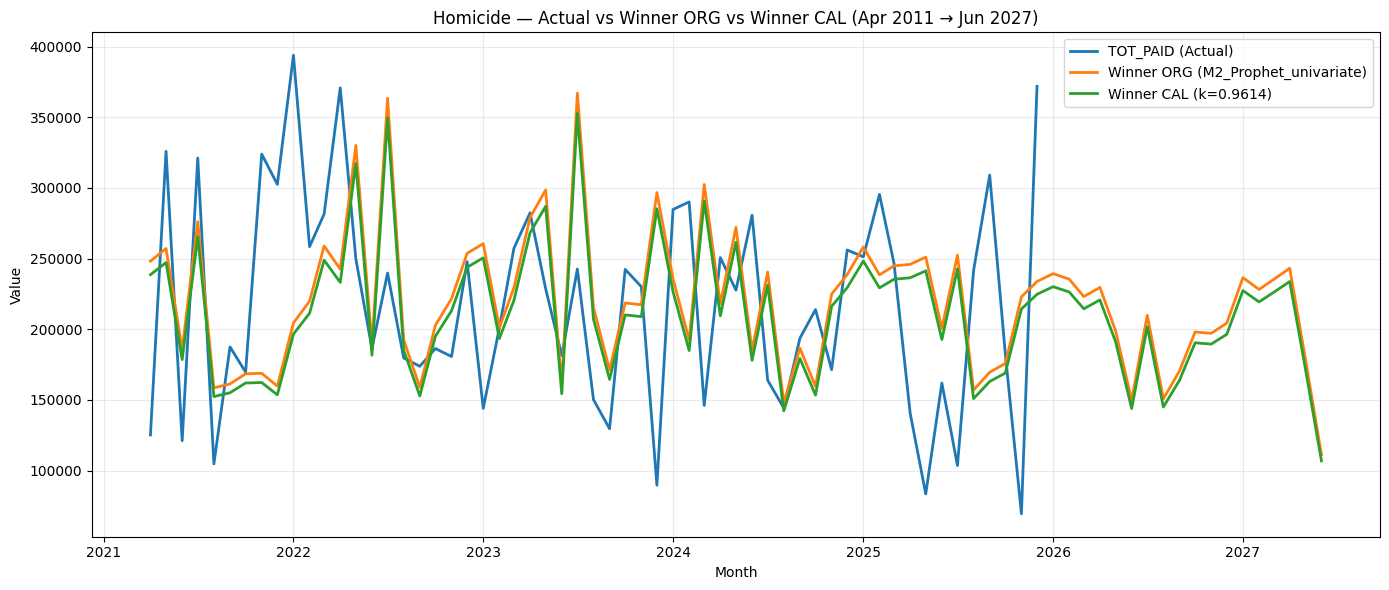

✅ Displayed plot for group: Homicide


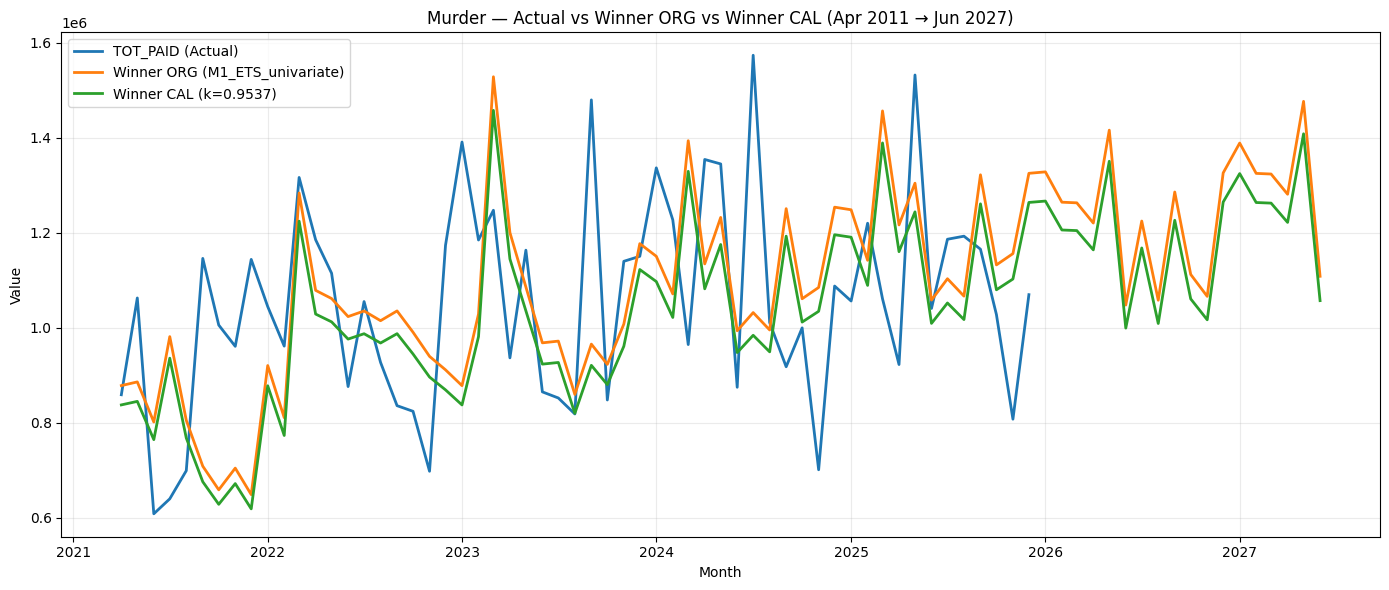

✅ Displayed plot for group: Murder


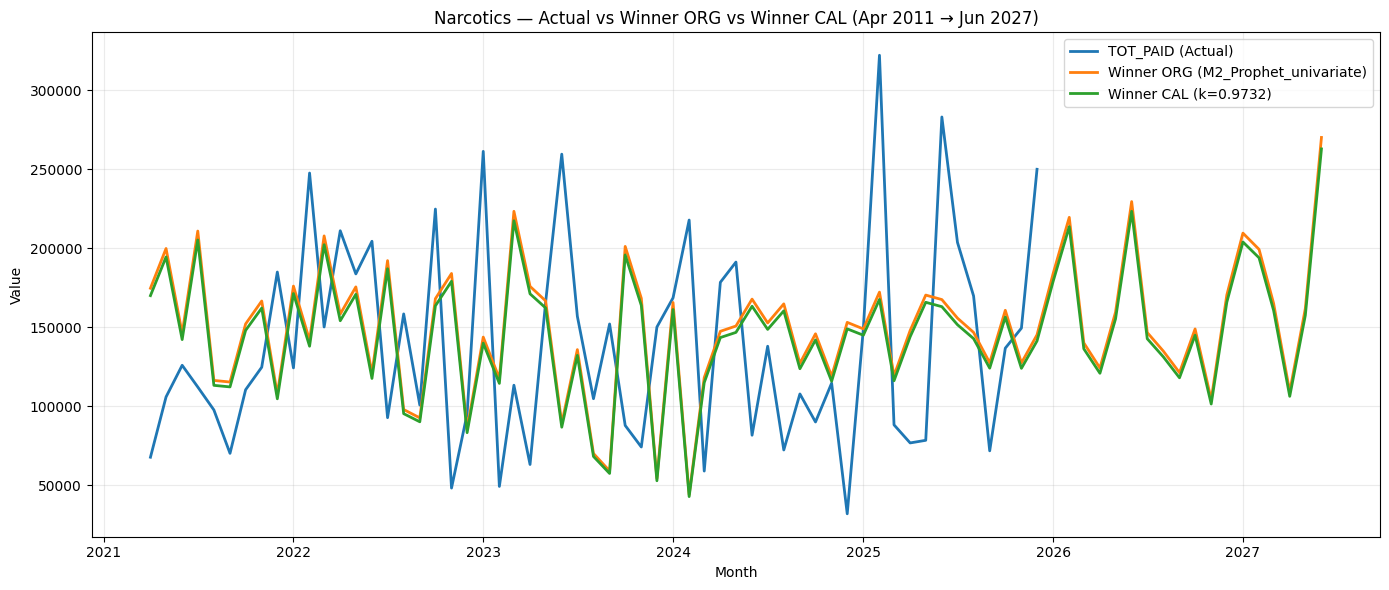

✅ Displayed plot for group: Narcotics


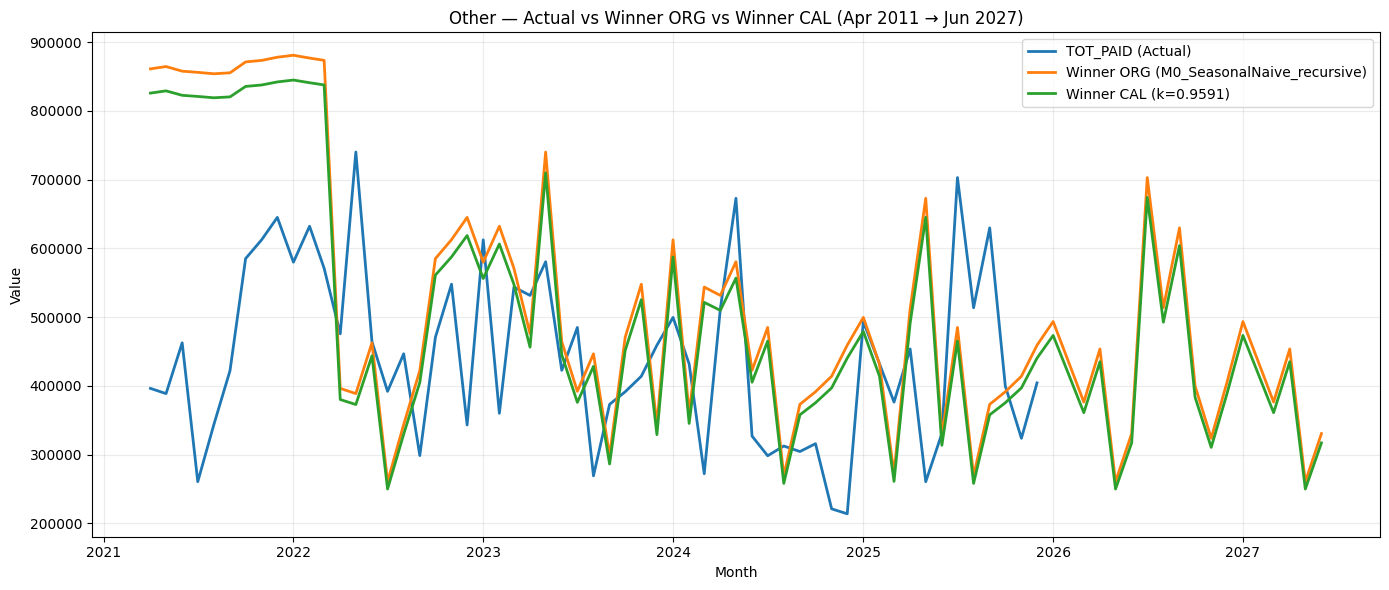

✅ Displayed plot for group: Other


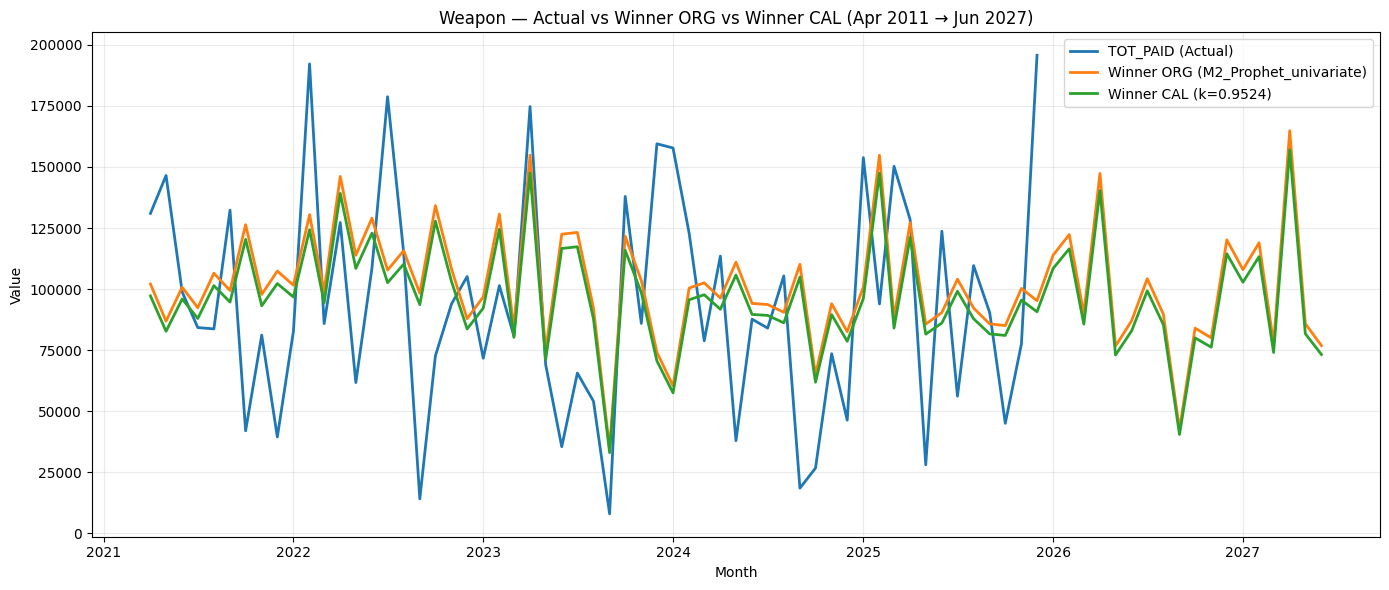

✅ Displayed plot for group: Weapon


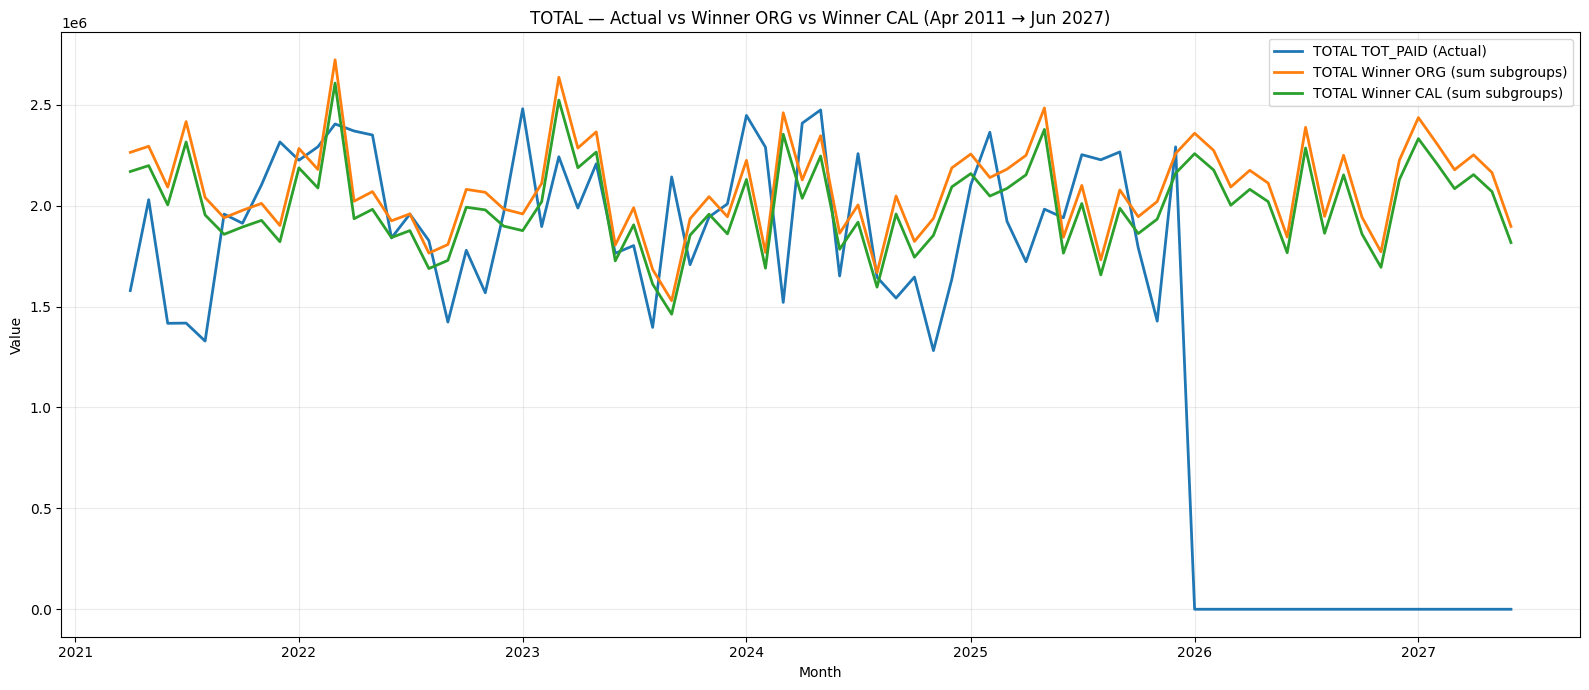


✅ Displayed TOTAL plot (no files saved).


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# CONFIG
# ============================================================
OUTPUT_ROOT = r"\\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\Output_MultiTrend"
INPUT_PATH  = r"\\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\0_data_input_monthly_2.csv"

DATE_COL = "ACC_MONTH"
Y_COL    = "TOT_PAID"

# Try these names to find the group column in your input
GROUP_COL_CANDIDATES = [
    "product_report", "Product_Report", "PRODUCT_REPORT",
    "product", "Product", "PRODUCT",
    "subgroup", "Subgroup", "SUBGROUP",
    "group", "Group", "GROUP"
]

# Plot window
PLOT_START = pd.Timestamp("2011-04-01")
PLOT_END   = pd.Timestamp("2027-06-01")  # inclusive

# Per-group files expected under OUTPUT_ROOT\<group>\...
FN_MONTHLY   = "backtest_monthly_org.csv"
FN_SUMMARY   = "winner_selection_and_calibration_summary.csv"  # must contain winner_model, k_factor
FN_WIN_FC    = "forecast_winner_18m_org_cal.csv"               # preferred if present
FN_ALL_FC    = "forecast_all_models_18m_org.csv"               # fallback if WIN_FC missing


# ============================================================
# HELPERS
# ============================================================
def ensure_dt(s):
    return pd.to_datetime(s, errors="coerce")

def month_start(ts):
    ts = pd.Timestamp(ts)
    return ts.to_period("M").to_timestamp(how="start")

def safe_read_csv(path):
    if not os.path.exists(path):
        return pd.DataFrame()
    try:
        return pd.read_csv(path)
    except Exception as e:
        print(f"⚠️ Could not read {path}: {type(e).__name__}: {e}")
        return pd.DataFrame()

def detect_group_col(df_cols):
    cols_set = set(df_cols)
    for c in GROUP_COL_CANDIDATES:
        if c in cols_set:
            return c
    # also try case-insensitive match
    lower_map = {c.lower(): c for c in df_cols}
    for c in GROUP_COL_CANDIDATES:
        if c.lower() in lower_map:
            return lower_map[c.lower()]
    return None

def latest_operational_forecast(monthly_df, model, months):
    """
    For each ds in months, choose latest cutoff < ds for that model.
    monthly_df must have: cutoff, ds, model, y_actual, yhat
    """
    if monthly_df.empty:
        return pd.DataFrame()

    m = monthly_df.copy()
    m["ds"] = ensure_dt(m.get("ds"))
    m["cutoff"] = ensure_dt(m.get("cutoff"))
    m["model"] = m.get("model").astype(str)

    for c in ["y_actual", "yhat"]:
        if c in m.columns:
            m[c] = pd.to_numeric(m[c], errors="coerce")

    m = m.dropna(subset=["ds", "cutoff"]).copy()
    m = m[m["model"] == str(model)].copy()
    if m.empty:
        return pd.DataFrame()

    months = pd.to_datetime(months)
    m = m[m["ds"].isin(months)].copy()
    m = m[m["cutoff"] < m["ds"]].copy()
    if m.empty:
        return pd.DataFrame()

    m = m.sort_values(["ds", "cutoff"])
    out = m.groupby(["ds"], as_index=False).tail(1).copy()
    out = out.sort_values("ds").reset_index(drop=True)
    return out[["ds", "y_actual", "yhat"]]


# ============================================================
# LOAD INPUT ACTUALS
# ============================================================
df = pd.read_csv(INPUT_PATH)
df.columns = [c.strip() for c in df.columns]

if DATE_COL not in df.columns:
    raise ValueError(f"Missing {DATE_COL} in input file")
if Y_COL not in df.columns:
    raise ValueError(f"Missing {Y_COL} in input file")

GROUP_COL = detect_group_col(df.columns)
if GROUP_COL is None:
    raise ValueError(
        "Could not find the group column in input file. "
        f"Tried: {GROUP_COL_CANDIDATES}. "
        f"Available columns: {list(df.columns)}"
    )

print(f"✅ Using group column: {GROUP_COL}")

df[DATE_COL] = ensure_dt(df[DATE_COL])
df = df.dropna(subset=[DATE_COL]).copy()
df[DATE_COL] = df[DATE_COL].dt.to_period("M").dt.to_timestamp(how="start")

df[Y_COL] = pd.to_numeric(df[Y_COL], errors="coerce")
df = df.dropna(subset=[Y_COL]).copy()

# Limit to requested plot window
df = df[(df[DATE_COL] >= PLOT_START) & (df[DATE_COL] <= PLOT_END)].copy()

# Aggregate actuals by (group, month) in case duplicates exist
actual_by_group = (
    df.groupby([GROUP_COL, DATE_COL], as_index=False)[Y_COL]
      .sum()
      .rename(columns={DATE_COL: "ds", Y_COL: "y_actual"})
)


# ============================================================
# PROCESS GROUP FOLDERS (IGNORE UNDERSCORE FOLDERS LIKE _plots)
# ============================================================
group_folders = [
    os.path.join(OUTPUT_ROOT, f)
    for f in os.listdir(OUTPUT_ROOT)
    if os.path.isdir(os.path.join(OUTPUT_ROOT, f)) and not f.startswith("_")
]

all_group_series = []

for group_folder in sorted(group_folders):
    group_name = os.path.basename(group_folder)

    path_monthly = os.path.join(group_folder, FN_MONTHLY)
    path_summary = os.path.join(group_folder, FN_SUMMARY)
    path_win_fc  = os.path.join(group_folder, FN_WIN_FC)
    path_all_fc  = os.path.join(group_folder, FN_ALL_FC)

    monthly = safe_read_csv(path_monthly)
    summ    = safe_read_csv(path_summary)

    if monthly.empty or summ.empty:
        print(f"⚠️ Skip {group_name}: missing {FN_MONTHLY} or {FN_SUMMARY}.")
        continue

    # Winner + k
    winner_model = None
    k_factor = 1.0
    if "winner_model" in summ.columns and len(summ):
        winner_model = str(summ.loc[0, "winner_model"])
    if "k_factor" in summ.columns and len(summ):
        try:
            k_factor = float(summ.loc[0, "k_factor"])
        except Exception:
            k_factor = 1.0

    if not winner_model:
        print(f"⚠️ Skip {group_name}: winner_model missing in summary.")
        continue

    # last actual month from monthly file (safe)
    monthly["ds"] = ensure_dt(monthly.get("ds"))
    if monthly["ds"].dropna().empty:
        print(f"⚠️ Skip {group_name}: monthly ds is empty.")
        continue
    last_actual = month_start(pd.Timestamp(monthly["ds"].max()))

    # history months
    hist_months = pd.date_range(PLOT_START, min(last_actual, PLOT_END), freq="MS")

    # operational org for history
    hist_fc = latest_operational_forecast(monthly, winner_model, hist_months)
    if hist_fc.empty:
        print(f"⚠️ {group_name}: no operational history rows for {winner_model}.")
        continue

    hist_fc = hist_fc.rename(columns={"yhat": "yhat_org"})
    hist_fc["yhat_cal"] = hist_fc["yhat_org"] * float(k_factor)

    # merge actuals from input for this group (if group names match exactly)
    g_actual = actual_by_group[actual_by_group[GROUP_COL].astype(str) == str(group_name)].copy()
    g_actual = g_actual[["ds", "y_actual"]].copy()

    hist = hist_fc.merge(g_actual, on="ds", how="left", suffixes=("_monthly", ""))
    if "y_actual_monthly" in hist.columns:
        hist["y_actual"] = hist["y_actual"].where(hist["y_actual"].notna(), hist["y_actual_monthly"])
        hist = hist.drop(columns=["y_actual_monthly"])

    hist["segment"] = "history"

    # FUTURE: prefer forecast_winner_18m_org_cal.csv if present; else fallback to forecast_all_models_18m_org.csv
    fut = pd.DataFrame(columns=["ds", "yhat_org", "yhat_cal", "y_actual", "segment"])
    win_fc = safe_read_csv(path_win_fc)

    if not win_fc.empty and "ds" in win_fc.columns:
        win_fc["ds"] = ensure_dt(win_fc["ds"])
        win_fc["yhat_org"] = pd.to_numeric(win_fc.get("yhat_org"), errors="coerce")
        win_fc["yhat_cal"] = pd.to_numeric(win_fc.get("yhat_cal"), errors="coerce")
        fut = win_fc[["ds", "yhat_org", "yhat_cal"]].copy()
        fut["y_actual"] = np.nan
        fut["segment"] = "future"
    else:
        all_fc = safe_read_csv(path_all_fc)
        if not all_fc.empty and "ds" in all_fc.columns and winner_model in all_fc.columns:
            all_fc["ds"] = ensure_dt(all_fc["ds"])
            all_fc[winner_model] = pd.to_numeric(all_fc[winner_model], errors="coerce")
            fut = all_fc[["ds", winner_model]].rename(columns={winner_model: "yhat_org"}).copy()
            fut["yhat_cal"] = fut["yhat_org"] * float(k_factor)
            fut["y_actual"] = np.nan
            fut["segment"] = "future"

    if not fut.empty:
        fut = fut[(fut["ds"] > last_actual) & (fut["ds"] >= PLOT_START) & (fut["ds"] <= PLOT_END)].copy()

    ser = pd.concat(
        [hist[["ds", "y_actual", "yhat_org", "yhat_cal", "segment"]], fut],
        ignore_index=True
    ).sort_values("ds").reset_index(drop=True)

    ser["group"] = group_name
    ser["winner_model"] = winner_model
    ser["k_factor"] = float(k_factor)
    ser = ser[(ser["ds"] >= PLOT_START) & (ser["ds"] <= PLOT_END)].copy()

    all_group_series.append(ser)

    # ============================================================
    # PLOT 1: per subgroup (DISPLAY ONLY - NO SAVING)
    # ============================================================
    plt.figure(figsize=(14, 6))
    plt.plot(ser["ds"], ser["y_actual"], linewidth=2, label="TOT_PAID (Actual)")
    plt.plot(ser["ds"], ser["yhat_org"], linewidth=2, label=f"Winner ORG ({winner_model})")
    plt.plot(ser["ds"], ser["yhat_cal"], linewidth=2, label=f"Winner CAL (k={k_factor:.4f})")

    plt.title(f"{group_name} — Actual vs Winner ORG vs Winner CAL (Apr 2011 → Jun 2027)")
    plt.xlabel("Month")
    plt.ylabel("Value")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"✅ Displayed plot for group: {group_name}")


# ============================================================
# PLOT 2: totals across all subgroups (DISPLAY ONLY - NO SAVING)
# ============================================================
if not all_group_series:
    raise RuntimeError("No group plots generated. Check that OUTPUT_ROOT has subgroup folders and files.")

all_df = pd.concat(all_group_series, ignore_index=True)

tot = (
    all_df.groupby("ds", as_index=False)
          .agg(
              total_actual=("y_actual", "sum"),
              total_org=("yhat_org", "sum"),
              total_cal=("yhat_cal", "sum"),
          )
)

# Ensure continuous month axis
full_months = pd.date_range(PLOT_START, PLOT_END, freq="MS")
tot = tot.set_index("ds").reindex(full_months).reset_index().rename(columns={"index": "ds"})

plt.figure(figsize=(16, 7))
plt.plot(tot["ds"], tot["total_actual"], linewidth=2, label="TOTAL TOT_PAID (Actual)")
plt.plot(tot["ds"], tot["total_org"], linewidth=2, label="TOTAL Winner ORG (sum subgroups)")
plt.plot(tot["ds"], tot["total_cal"], linewidth=2, label="TOTAL Winner CAL (sum subgroups)")

plt.title("TOTAL — Actual vs Winner ORG vs Winner CAL (Apr 2011 → Jun 2027)")
plt.xlabel("Month")
plt.ylabel("Value")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

print("\n✅ Displayed TOTAL plot (no files saved).")
